# Factors Influencing Academic Performance: A Data-Driven Analysis of Student Grades at UCSD
## Spring 2022 Enrollment Data

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.formula.api as smf
from sklearn.linear_model import Lasso
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import shapiro, probplot
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

## Data Cleaning

In [2]:
# Load the TSV file
file_path = 'cape.tsv'
data = pd.read_csv(file_path, sep='\t')
sp22 = pd.read_csv('SP22.tsv', sep = '\t')

# Display the first few rows of the dataframe
data = data[data['term'] == 'SP22']
data.head()

instructor sub_course                          course  term  \
10       Smith, Neil Gordon   ANAR 104       Intro GIS for Anth & Arch  SP22   
11       Smith, Neil Gordon   ANAR 143                   Biblical Arch  SP22   
12  D'Alpoim Guedes, Jade A   ANAR 146               Feeding the World  SP22   
13    Braswell, Geoffrey E.   ANAR 155  Stdy Abrd: Ancient Mesoamerica  SP22   
14        Goldstein, Paul S   ANAR 156    Archaeology of South America  SP22   

    enroll  evals_made  rcmd_class  rcmd_instr  study_hr_wk  avg_grade_exp  \
10    10.0         6.0       100.0       100.0         3.83           4.00   
11    36.0         7.0        85.7        85.7         4.50           3.57   
12    78.0        20.0        95.0       100.0         5.80           3.84   
13    23.0        16.0       100.0       100.0         2.63           3.94   
14    36.0        10.0        80.0       100.0         4.30           3.70   

    avg_grade_rec  
10          -1.00  
11           3.33  
12           3.38  
13           3.97  
14           3.81

In [3]:
# Rename the column 'old_column_name' to 'new_column_name'
sp22 = sp22.rename(columns={'subj_course_id': 'sub_course'})

# Display the merged DataFrame
sp22 = sp22[['sub_course', 'total_seats', 'meetings' ]]
sp22.head()

sub_course  total_seats                                           meetings
0     AAS 10           34  LE,TuTh,17:00 - 18:20,MANDE B-150|DI,M,15:00 -...
1     AAS 10           34  LE,TuTh,17:00 - 18:20,MANDE B-150|DI,W,16:00 -...
2    AAS 190           44                    SE,TuTh,11:00 - 12:20,SOLIS 111
3    AAS 198           20                         IN,N/A,0:00 - 0:00,TBA TBA
4    AAS 500            2                         PR,N/A,0:00 - 0:00,TBA TBA

In [4]:
# Function to extract class schedule
def extract_schedule(meetings):
    try:
        return meetings.split(',')[1]
    except IndexError:
        return None

# Function to calculate class length in minutes
def calculate_class_length(meetings):
    try:
        time_range = meetings.split(',')[2]
        start_time, end_time = time_range.split('-')
        start_hour, start_minute = map(int, start_time.split(':'))
        end_hour, end_minute = map(int, end_time.split(':'))
        return (end_hour * 60 + end_minute) - (start_hour * 60 + start_minute)
    except (IndexError, ValueError):
        return None

# Apply functions to create new columns
sp22['class_schedule'] = sp22['meetings'].apply(extract_schedule)
sp22['class_length'] = sp22['meetings'].apply(calculate_class_length)
sp22.head()

sub_course  total_seats                                           meetings  \
0     AAS 10           34  LE,TuTh,17:00 - 18:20,MANDE B-150|DI,M,15:00 -...   
1     AAS 10           34  LE,TuTh,17:00 - 18:20,MANDE B-150|DI,W,16:00 -...   
2    AAS 190           44                    SE,TuTh,11:00 - 12:20,SOLIS 111   
3    AAS 198           20                         IN,N/A,0:00 - 0:00,TBA TBA   
4    AAS 500            2                         PR,N/A,0:00 - 0:00,TBA TBA   

  class_schedule  class_length  
0           TuTh            80  
1           TuTh            80  
2           TuTh            80  
3            N/A             0  
4            N/A             0

In [5]:
final_result = pd.merge(sp22, data, on=['sub_course'], how='inner')
final_result.columns

Index(['sub_course', 'total_seats', 'meetings', 'class_schedule',
       'class_length', 'instructor', 'course', 'term', 'enroll', 'evals_made',
       'rcmd_class', 'rcmd_instr', 'study_hr_wk', 'avg_grade_exp',
       'avg_grade_rec'],
      dtype='object')

In [6]:
data = final_result[['sub_course', 'total_seats', 'class_schedule',
       'class_length', 'enroll', 'evals_made','rcmd_class', 'rcmd_instr', 'study_hr_wk', 'avg_grade_exp',
       'avg_grade_rec']]

In [7]:
data.head()

sub_course  total_seats class_schedule  class_length  enroll  evals_made  \
0   ANAR 104           16           TuTh            80    10.0         6.0   
1   ANAR 143           44           TuTh            80    36.0         7.0   
2   ANAR 146           80           TuTh            80    78.0        20.0   
3   ANAR 155           24              F           170    23.0        16.0   
4   ANAR 156           39           TuTh            80    36.0        10.0   

   rcmd_class  rcmd_instr  study_hr_wk  avg_grade_exp  avg_grade_rec  
0       100.0       100.0         3.83           4.00          -1.00  
1        85.7        85.7         4.50           3.57           3.33  
2        95.0       100.0         5.80           3.84           3.38  
3       100.0       100.0         2.63           3.94           3.97  
4        80.0       100.0         4.30           3.70           3.81

> Create department categorical variable

In [8]:
data.sub_course.str.split(' ').str[0].unique()
course_mapping = {
    "AAPI": "Asian American and Pacific Islander Studies",
    "AAS": "African American Studies",
    "AESE": "Architecture Based Enterprise Systems Engineering",
    "AIP": "Academic Internship Program",
    "ANAR": "Anthropological Archaeology",
    "ANBI": "Anthropology Biological Anthropology",
    "ANES": "Anesthesiology",
    "ANSC": "Anthro Sociocultural Anthropology",
    "ANTH": "Anthropology",
    "ASTR": "Astronomy and Astrophysics",
    "AUD": "Audiology",
    "AWP": "Analytical Writing Program",
    "BENG": "Bioengineering",
    "BGGN": "Biology Grad General",
    "BGJC": "Biology Grad Journal Club",
    "BGRD": "Biology Grad Research Discussion",
    "BGSE": "Biology Grad Seminar",
    "BIBC": "Biology Biochemistry",
    "BICD": "Biology Genetics Cellular and Developmental",
    "BIEB": "Biology Ecology Behavior and Evolutionary",
    "BILD": "Biology Lower Division",
    "BIMM": "Biology Molecular Biology Microbiology",
    "BIOM": "Biomedical Sciences",
    "BIPN": "Biology Animal Physiology and Neuroscience",
    "BISP": "Biology Special Studies",
    "BNFO": "Bioinformatics",
    "CAT": "Culture Art and Technology",
    "CCE": "Critical Community Engagement",
    "CCS": "Climate Change Studies",
    "CENG": "Chemical Engineering",
    "CGS": "Critical Gender Studies",
    "CHEM": "Chemistry and Biochemistry",
    "CHIN": "Chinese Studies",
    "CLAS": "Classical Studies",
    "CLIN": "Clinical Psychology",
    "CLRE": "Clinical Research",
    "CLSS": "Classics",
    "CLX": "Chicanx and Latinx Studies",
    "CMM": "Cellular & Molecular Medicine",
    "COGR": "Communication Graduate",
    "COGS": "Cognitive Science",
    "COMM": "Communication",
    "CONT": "Contemporary Issues",
    "COSE": "Convergent Systems Engineering",
    "CSE": "Computer Science and Engineering",
    "CSS": "Computational Social Science",
    "DDPM": "Drug Development and Product Management",
    "DERM": "Dermatology",
    "DOC": "Dimensions of Culture",
    "DSC": "Data Science",
    "DSE": "Data Science and Engineering",
    "DSGN": "Design",
    "EAP": "Education Abroad Program",
    "ECE": "Electrical and Computer Engineering",
    "ECON": "Economics",
    "EDS": "Education Studies",
    "EIGH": "Eighth College",
    "EMED": "Emergency Medicine",
    "ENG": "Engineering",
    "ENVR": "Environmental Studies",
    "ERC": "Eleanor Roosevelt College",
    "ESYS": "Environmental Systems",
    "ETHN": "Ethnic Studies",
    "ETIM": "Ethnic Studies Interdisciplinary Research Methods",
    "EXPR": "Exchange Programs",
    "FILM": "Film Studies",
    "FMPH": "Family Medicine and Public Health",
    "FPM": "Family and Preventive Medicine",
    "GLBH": "Global Health",
    "GMST": "German Studies Program",
    "GPCO": "GPS Core",
    "GPEC": "GPS Economics",
    "GPGN": "GPS General",
    "GPIM": "GPS International Management",
    "GPLA": "GPS Language",
    "GPPA": "GPS Policy Analytics",
    "GPPS": "GPS Political Science",
    "GSS": "Global South Studies",
    "HDP": "Human Development Program",
    "HDS": "Human Developmental Sciences",
    "HIAF": "History of Africa",
    "HIEA": "History of East Asia",
    "HIEU": "History of Europe",
    "HIGL": "History Global",
    "HIGR": "History Graduate",
    "HILA": "History of Latin America",
    "HILD": "History Lower Division",
    "HINE": "History of the Near East",
    "HISA": "History of South Asia",
    "HISC": "History of Science",
    "HITO": "History Topics",
    "HIUS": "History of the United States",
    "HLAW": "Health Law",
    "HMNR": "Human Rights",
    "HUM": "Humanities",
    "ICEP": "Intercampus Exchange Program",
    "INTL": "International Studies",
    "IRLA": "International Relations Pacific Study-Language",
    "JAPN": "Japanese Studies",
    "JWSP": "Jewish Studies Program",
    "LATI": "Latin American Studies",
    "LAWS": "Law and Society",
    "LHCO": "Leadership Health Care Organizations",
    "LIAB": "Linguistics Arabic",
    "LIDS": "Linguistics Directed Study-Language",
    "LIEO": "Linguistics Esperanto",
    "LIFR": "Linguistics French",
    "LIGM": "Linguistics German",
    "LIGN": "Linguistics General",
    "LIHI": "Linguistics Hindi",
    "LIHL": "Linguistics Heritage Languages",
    "LIIT": "Linguistics Italian",
    "LIPO": "Linguistics Portuguese",
    "LISL": "Linguistics American Sign Language",
    "LISP": "Linguistics Spanish",
    "LTAF": "Literature African",
    "LTAM": "Literature of the Americas",
    "LTCH": "Literature Chinese",
    "LTCO": "Literature Comparative",
    "LTCS": "Literature Cultural Studies",
    "LTEA": "Literatures East Asian",
    "LTEN": "Literatures in English",
    "LTEU": "Literature European and Eurasian",
    "LTFR": "Literature French",
    "LTGK": "Literature Greek",
    "LTGM": "Literature German",
    "LTIT": "Literature Italian",
    "LTKO": "Literature Korean",
    "LTLA": "Literature Latin",
    "LTRU": "Literature Russian",
    "LTSP": "Literature Spanish",
    "LTTH": "Literature Theory",
    "LTWL": "Literatures of the World",
    "LTWR": "Literature Writing",
    "MAE": "Mechanical and Aerospace Engineering",
    "MATH": "Mathematics",
    "MATS": "Materials Science and Engineering",
    "MBC": "Marine Biodiversity & Conservation",
    "MCWP": "Muir College Writing Program",
    "MDE": "Medical Device Engineering",
    "MED": "Medicine",
    "MGT": "Rady School of Management",
    "MGTA": "Rady School of Management Business Analytics",
    "MGTF": "Rady School of Management Finance",
    "MGTP": "Rady School of Management Professional Accountancy",
    "MMW": "Making of the Modern World",
    "MSED": "Mathematics and Science Education",
    "MSP": "Muir Special Projects",
    "MUIR": "Muir College",
    "MUS": "Music",
    "NANO": "Nanoengineering",
    "NEU": "Neurosciences",
    "NEUG": "Neurosciences Graduate",
    "OBG": "Obstetrics and Gynecology",
    "OPTH": "Ophthalmology",
    "ORTH": "Orthopedics",
    "PAE": "Physician Assistant Education",
    "PATH": "Pathology",
    "PEDS": "Pediatrics",
    "PH": "Public Health",
    "PHAR": "Pharmacology",
    "PHB": "Public Health Biostatistics",
    "PHIL": "Philosophy",
    "PHLH": "Public Health Leadership Health Care Organizations",
    "PHYA": "Physics Astronomy",
    "PHYS": "Physics",
    "POLI": "Political Science",
    "PSY": "Psychiatry",
    "PSYC": "Psychology",
    "RAD": "Radiology",
    "RELI": "Study of Religion",
    "REV": "Revelle College",
    "RMAS": "Radiation Medicine and Applied Sciences",
    "RMED": "Reproductive Medicine",
    "SE": "Structural Engineering",
    "SEV": "Seventh College",
    "SIO": "Scripps Institution of Oceanography",
    "SIOB": "Scripps Institution of Oceanography Ocean Biosciences Program",
    "SIOC": "Scripps Institution of Oceanography Climate Oceans Atmosphere Program",
    "SIOG": "Scripps Institution of Oceanography Geosciences of Earth Oceans and Planets",
    "SOCE": "Sociology Individual Research and Honors Project",
    "SOCG": "Sociology Graduate",
    "SOCI": "Sociology",
    "SOCL": "Sociology Lower Division",
    "SOMC": "School of Medicine Core Courses",
    "SOMI": "School of Medicine Interdisciplinary",
    "SPPH": "SSPPS Pharmaceutical Sciences",
    "SPPS": "Pharmacy",
    "SURG": "Surgery",
    "SXTH": "Sixth College",
    "SYN": "Synthesis Program",
    "TDAC": "Theatre Acting",
    "TDDE": "Theatre Design",
    "TDDM": "Dance Dance Making",
    "TDDR": "Theatre Directing and Stage Management",
    "TDGE": "Theatre General",
    "TDGR": "Theatre Graduate",
    "TDHD": "Dance History",
    "TDHT": "Theatre History & Theory",
    "TDMV": "Dance Movement",
    "TDPF": "Dance Performance",
    "TDPR": "Theatre Dance Practicum",
    "TDPW": "Theatre Playwriting",
    "TDTR": "Dance Theory",
    "TKS": "Transnational Korean Studies",
    "TMC": "Thurgood Marshall College",
    "TWS": "Third World Studies",
    "UROL": "Urology",
    "USP": "Urban Studies and Planning",
    "VIS": "Visual Arts",
    "WARR": "Warren College",
    "WCWP": "Warren College Writing Program",
    "WES": "Wireless Embedded Systems"
}

data['department_name'] = data.sub_course.str.split(' ').str[0].map(course_mapping)
data.head()

sub_course  total_seats class_schedule  class_length  enroll  evals_made  \
0   ANAR 104           16           TuTh            80    10.0         6.0   
1   ANAR 143           44           TuTh            80    36.0         7.0   
2   ANAR 146           80           TuTh            80    78.0        20.0   
3   ANAR 155           24              F           170    23.0        16.0   
4   ANAR 156           39           TuTh            80    36.0        10.0   

   rcmd_class  rcmd_instr  study_hr_wk  avg_grade_exp  avg_grade_rec  \
0       100.0       100.0         3.83           4.00          -1.00   
1        85.7        85.7         4.50           3.57           3.33   
2        95.0       100.0         5.80           3.84           3.38   
3       100.0       100.0         2.63           3.94           3.97   
4        80.0       100.0         4.30           3.70           3.81   

               department_name  
0  Anthropological Archaeology  
1  Anthropological Archaeology  
2  Anthropological Archaeology  
3  Anthropological Archaeology  
4  Anthropological Archaeology

In [9]:
# Feature engineering: Create a new feature 'capacity_utilization'
data['capacity_utilization'] = (data['enroll'] / data['total_seats']).round(3)
data.head()

sub_course  total_seats class_schedule  class_length  enroll  evals_made  \
0   ANAR 104           16           TuTh            80    10.0         6.0   
1   ANAR 143           44           TuTh            80    36.0         7.0   
2   ANAR 146           80           TuTh            80    78.0        20.0   
3   ANAR 155           24              F           170    23.0        16.0   
4   ANAR 156           39           TuTh            80    36.0        10.0   

   rcmd_class  rcmd_instr  study_hr_wk  avg_grade_exp  avg_grade_rec  \
0       100.0       100.0         3.83           4.00          -1.00   
1        85.7        85.7         4.50           3.57           3.33   
2        95.0       100.0         5.80           3.84           3.38   
3       100.0       100.0         2.63           3.94           3.97   
4        80.0       100.0         4.30           3.70           3.81   

               department_name  capacity_utilization  
0  Anthropological Archaeology                 0.625  
1  Anthropological Archaeology                 0.818  
2  Anthropological Archaeology                 0.975  
3  Anthropological Archaeology                 0.958  
4  Anthropological Archaeology                 0.923

> Check the final dataset info

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7060 entries, 0 to 7059
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sub_course            7060 non-null   object 
 1   total_seats           7060 non-null   int64  
 2   class_schedule        7060 non-null   object 
 3   class_length          7060 non-null   int64  
 4   enroll                7060 non-null   float64
 5   evals_made            7060 non-null   float64
 6   rcmd_class            7060 non-null   float64
 7   rcmd_instr            7060 non-null   float64
 8   study_hr_wk           7060 non-null   float64
 9   avg_grade_exp         7060 non-null   float64
 10  avg_grade_rec         7060 non-null   float64
 11  department_name       7060 non-null   object 
 12  capacity_utilization  7060 non-null   float64
dtypes: float64(8), int64(2), object(3)
memory usage: 772.2+ KB


In [11]:
# cast categorical variable
data['department_name'] = data['department_name'].astype('category')
data['class_schedule'] = data['class_schedule'].astype('category')
data['class_length'] = data['class_length'].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7060 entries, 0 to 7059
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   sub_course            7060 non-null   object  
 1   total_seats           7060 non-null   int64   
 2   class_schedule        7060 non-null   category
 3   class_length          7060 non-null   category
 4   enroll                7060 non-null   float64 
 5   evals_made            7060 non-null   float64 
 6   rcmd_class            7060 non-null   float64 
 7   rcmd_instr            7060 non-null   float64 
 8   study_hr_wk           7060 non-null   float64 
 9   avg_grade_exp         7060 non-null   float64 
 10  avg_grade_rec         7060 non-null   float64 
 11  department_name       7060 non-null   category
 12  capacity_utilization  7060 non-null   float64 
dtypes: category(3), float64(8), int64(1), object(1)
memory usage: 630.9+ KB


> Null value Checking

In [12]:
# Display missing values

# Replace all negative values with NaN in the entire dataframe
data = data.applymap(lambda x: np.nan if isinstance(x, (int, float)) and x <= 0 else x)

missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 sub_course                0
total_seats             733
class_schedule            0
class_length             28
enroll                    0
evals_made                0
rcmd_class                0
rcmd_instr                0
study_hr_wk               0
avg_grade_exp            31
avg_grade_rec           673
department_name           0
capacity_utilization      1
dtype: int64


In [13]:
# Fill missing values with a placeholder
# data['instructor'].fillna('Unknown', inplace=True)
# data.fillna(data.mean(), inplace=True)

In [14]:
# Drop rows with missing values
data = data.dropna()
data = data.query('capacity_utilization <= 1')

> **Detect and remove outliers** (use 3 standard deviation as the threshold)

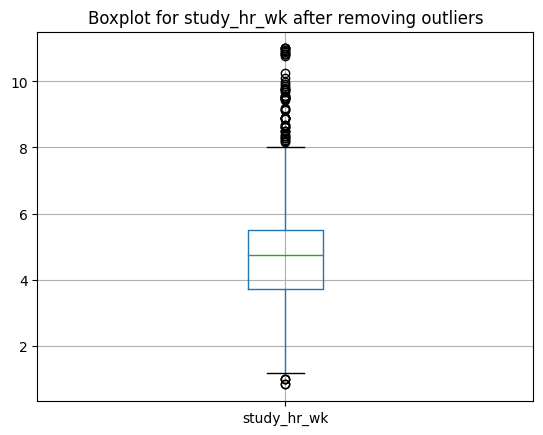

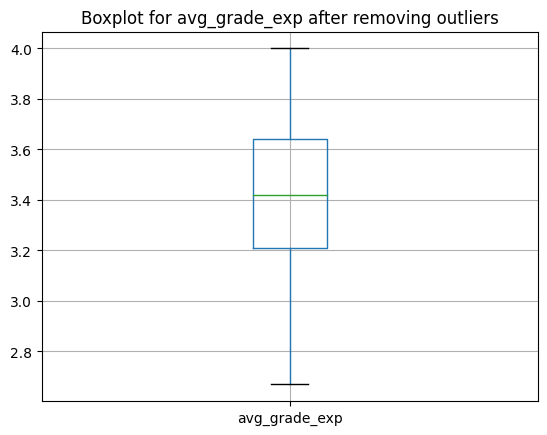


Outliers Removed:
 {'total_seats': 37, 'class_length': 1, 'enroll': 26, 'evals_made': 45, 'rcmd_class': 0, 'rcmd_instr': 24, 'study_hr_wk': 22, 'avg_grade_exp': 1, 'avg_grade_rec': 5, 'capacity_utilization': 33}


In [15]:
# Remove outliers that are more than three standard deviations away from the mean
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
outliers_removed = {}

# Select one or two columns for boxplots
columns_for_boxplot = ['study_hr_wk', 'avg_grade_exp']  # Example columns

for col in numerical_columns:
    mean = data[col].mean()
    std_dev = data[col].std()
    outliers = (data[col] - mean).abs() > (3 * std_dev)
    outliers_removed[col] = outliers.sum()
    data = data[~outliers]

    if col in columns_for_boxplot:
        # Optionally, visualize the boxplot after outlier removal
        data.boxplot(column=col)
        plt.title(f'Boxplot for {col} after removing outliers')
        plt.show()

# Print the number of outliers removed for each column
print("\nOutliers Removed:\n", outliers_removed)

> Ensure text fields are clean (check and remove possible whitespace existed in text)

In [16]:
whitespace_removed = {}

text_columns = data.select_dtypes(include=['object']).columns
for col in text_columns:
    whitespace_count = data[col].str.count(r'^\s+|\s+$').sum()
    whitespace_removed[col] = whitespace_count
    data[col] = data[col].str.strip()

print("\nWhitespace Removed:\n", whitespace_removed)


Whitespace Removed:
 {'sub_course': 0, 'class_schedule': 0, 'department_name': 0}


In [17]:
final_cleaned_file_path = 'SP22_cleaned.csv'
data.to_csv(final_cleaned_file_path, index=False)

## Exploratory Data Analysis (EDA)

> Descriptive Statistics

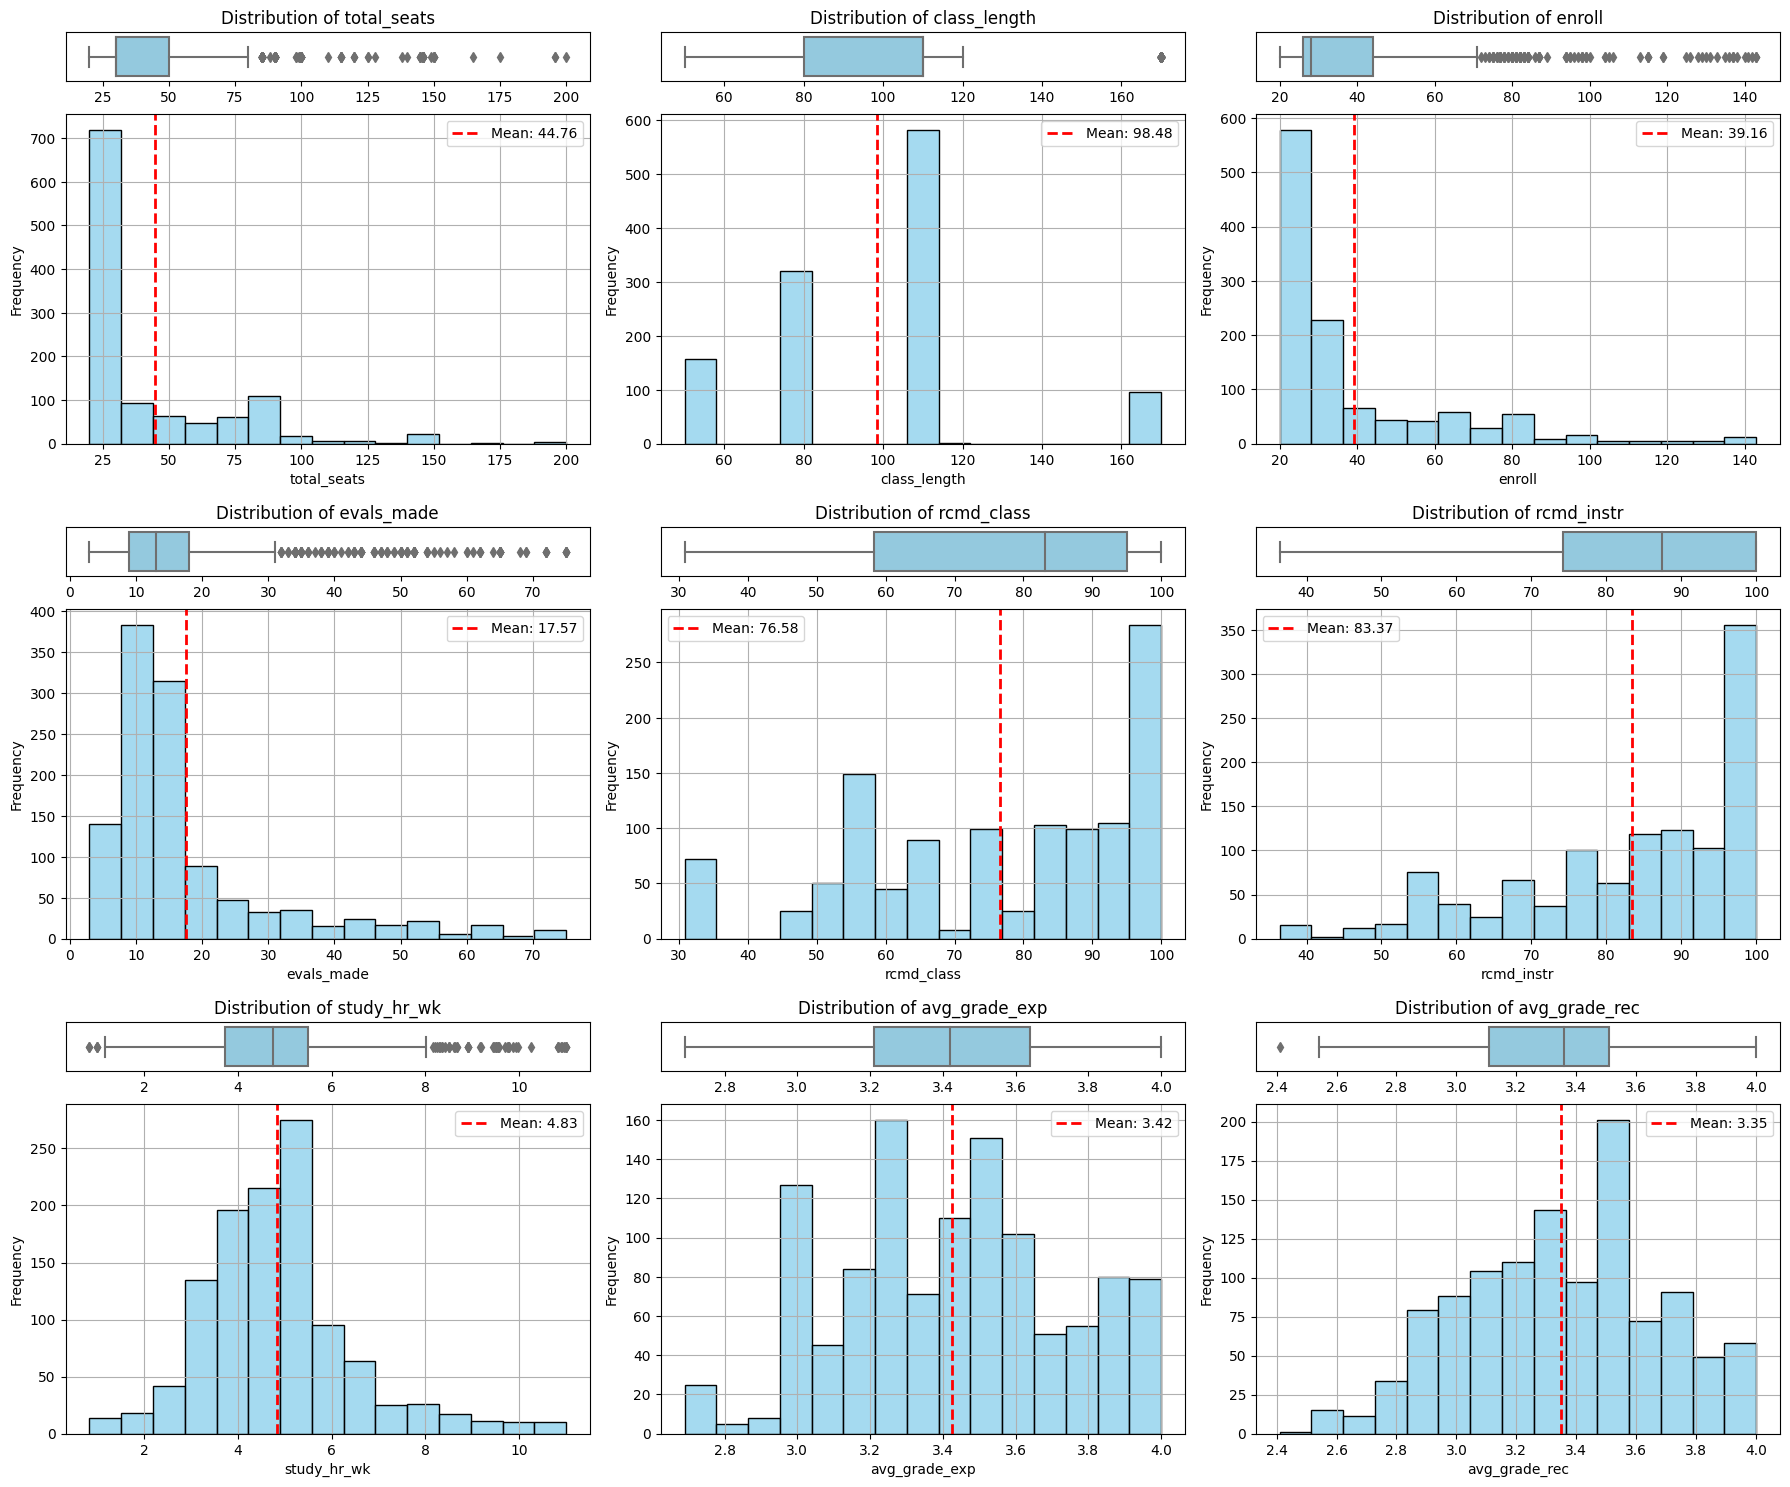

In [18]:
summary_stats = data.describe()

# Histograms for numerical columns
numerical_columns = ['total_seats', 'class_length', 'enroll', 'evals_made',
                     'rcmd_class', 'rcmd_instr', 'study_hr_wk', 'avg_grade_exp', 'avg_grade_rec']
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))
axes = axes.flatten()

for idx, col in enumerate(numerical_columns):
    ax_hist = axes[idx]
    ax_box = ax_hist.inset_axes([0, 1.1, 1, 0.15])

    sns.histplot(data[col], bins=15, kde=False, ax=ax_hist, color='skyblue')
    sns.boxplot(x=data[col], ax=ax_box, color='skyblue')

    mean_value = data[col].mean()
    median_value = data[col].median()
    percentiles = data[col].quantile([0.25, 0.75])

    ax_hist.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
    
    ax_hist.set_title(f'Distribution of {col}')
    ax_hist.set_xlabel(col)
    ax_hist.set_ylabel('Frequency')
    ax_hist.legend()
    ax_hist.grid(True)

    ax_box.set_title('')
    ax_box.set_xlabel('')
    ax_box.set_yticks([])


    
plt.tight_layout()
fig.savefig('histograms_with_boxplots.png')

plt.show()

> **Histograms** for numerical columns in subplots

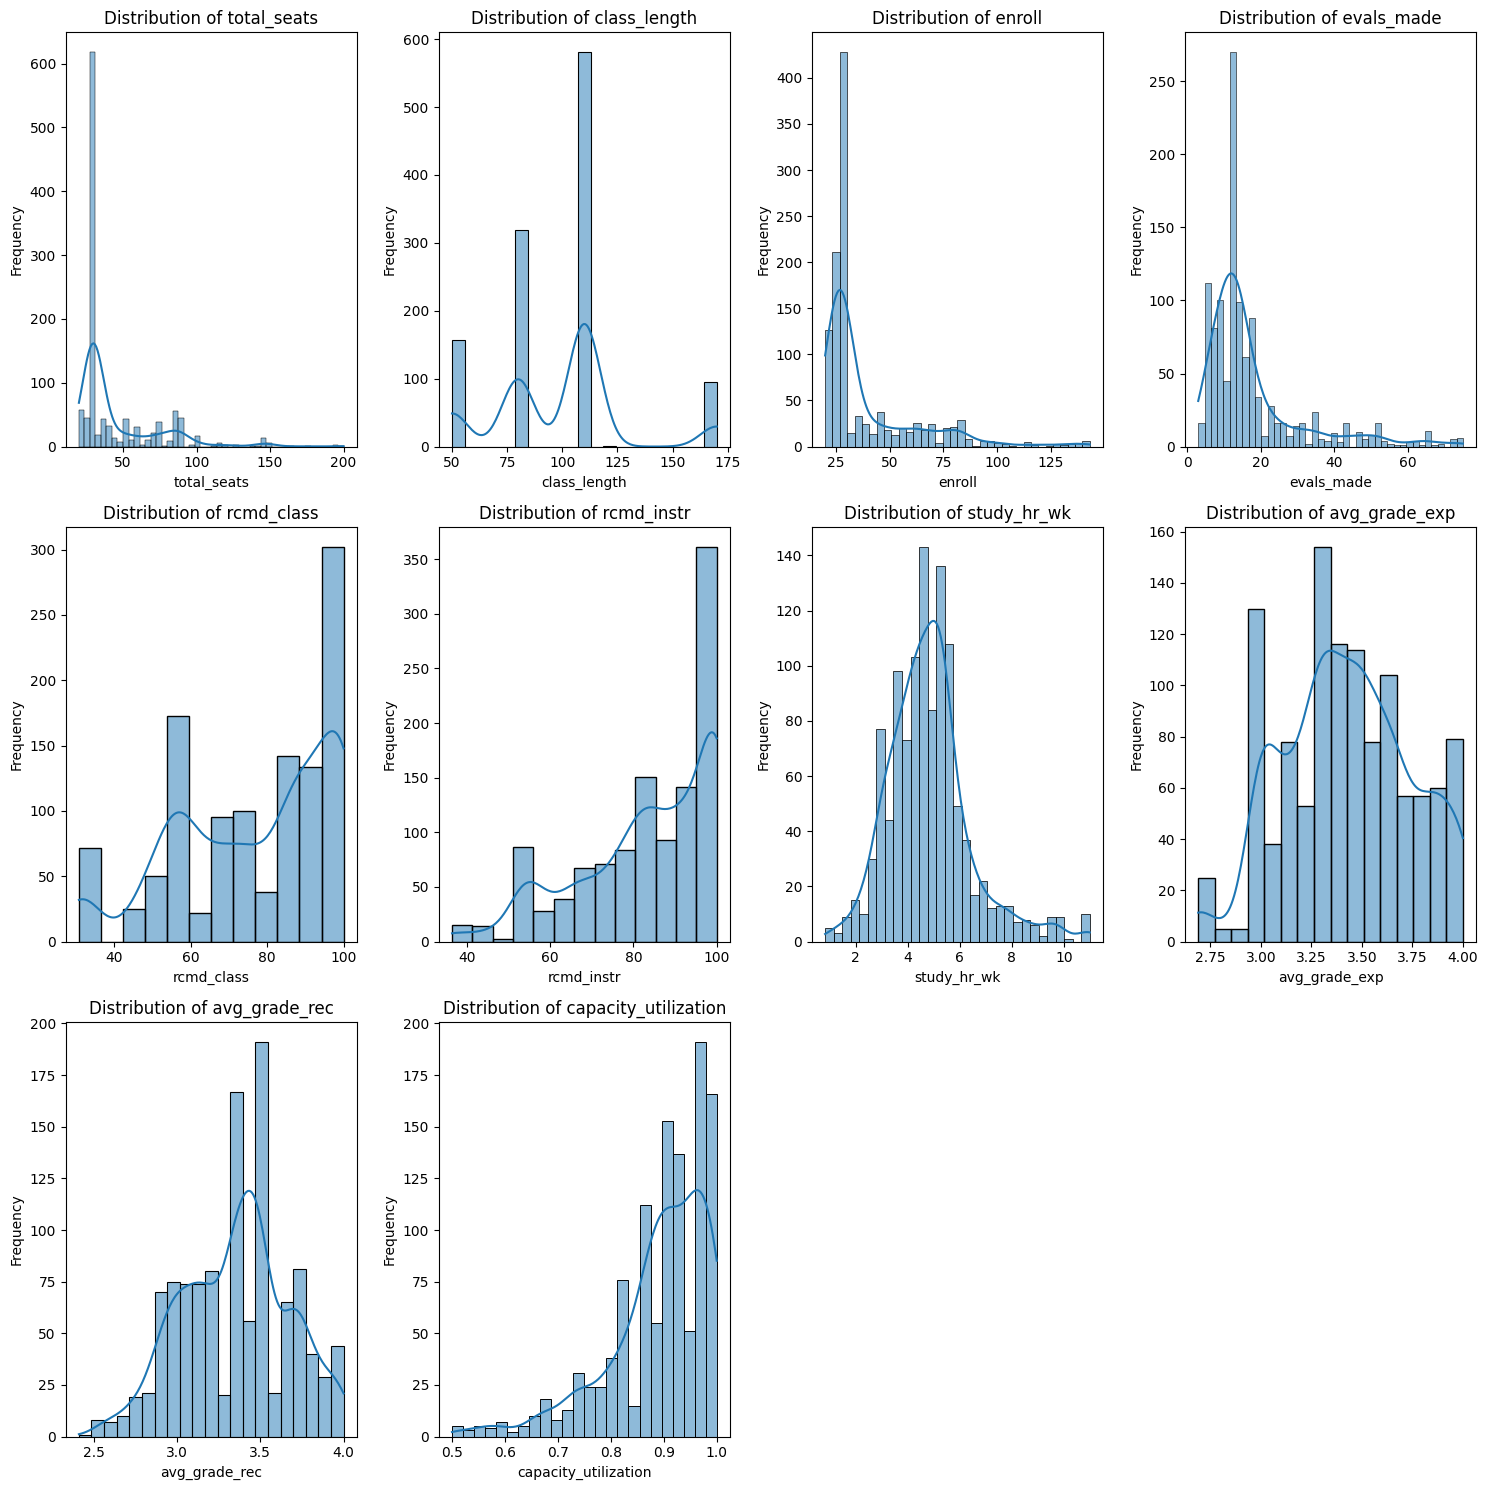

In [19]:
numerical_columns = data.select_dtypes(include=['float64']).columns

n_cols = 4
n_rows = int(np.ceil(len(numerical_columns) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

for i, col in enumerate(numerical_columns):
    row = i // n_cols
    col_pos = i % n_cols
    sns.histplot(data[col], kde=True, ax=axes[row, col_pos])
    axes[row, col_pos].set_title(f'Distribution of {col}')
    axes[row, col_pos].set_xlabel(col)
    axes[row, col_pos].set_ylabel('Frequency')

# Remove any empty subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

> Correlation matrix

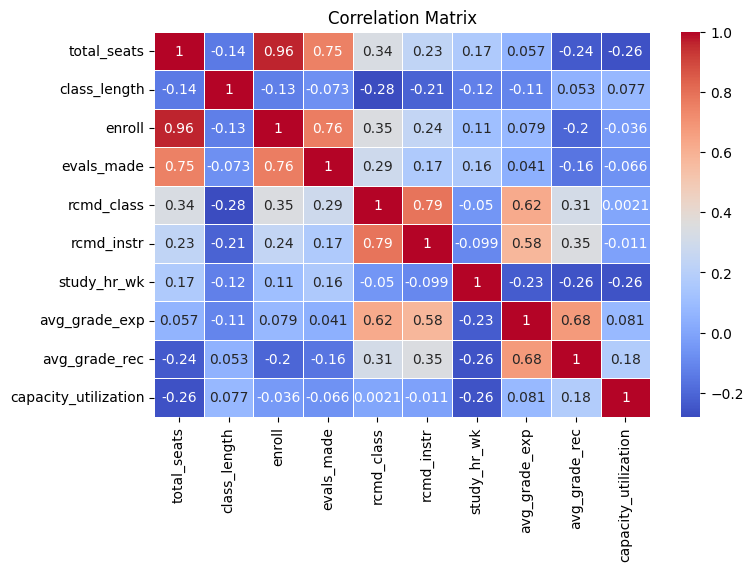

In [20]:
# Compute and visualize the correlation matrix
numerical_columns = data.select_dtypes(include=['float64']).columns
correlation_matrix = data[numerical_columns].corr()

plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

> Categorical Analysis

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1153 entries, 1 to 6851
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sub_course            1153 non-null   object 
 1   total_seats           1153 non-null   float64
 2   class_schedule        1153 non-null   object 
 3   class_length          1153 non-null   float64
 4   enroll                1153 non-null   float64
 5   evals_made            1153 non-null   float64
 6   rcmd_class            1153 non-null   float64
 7   rcmd_instr            1153 non-null   float64
 8   study_hr_wk           1153 non-null   float64
 9   avg_grade_exp         1153 non-null   float64
 10  avg_grade_rec         1153 non-null   float64
 11  department_name       1153 non-null   object 
 12  capacity_utilization  1153 non-null   float64
dtypes: float64(10), object(3)
memory usage: 126.1+ KB


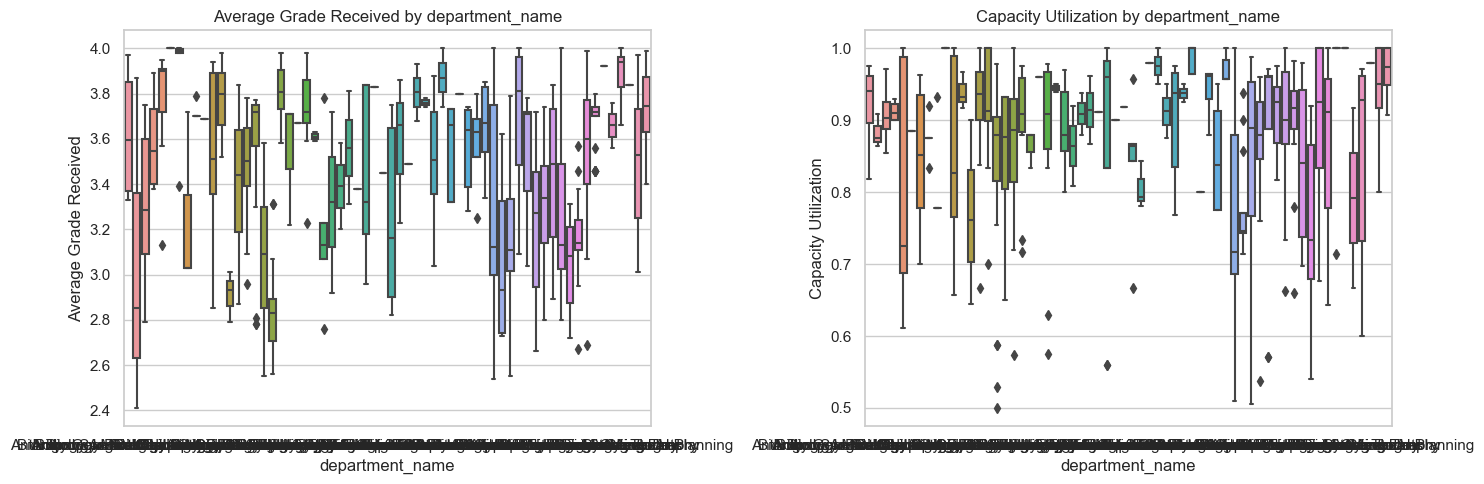

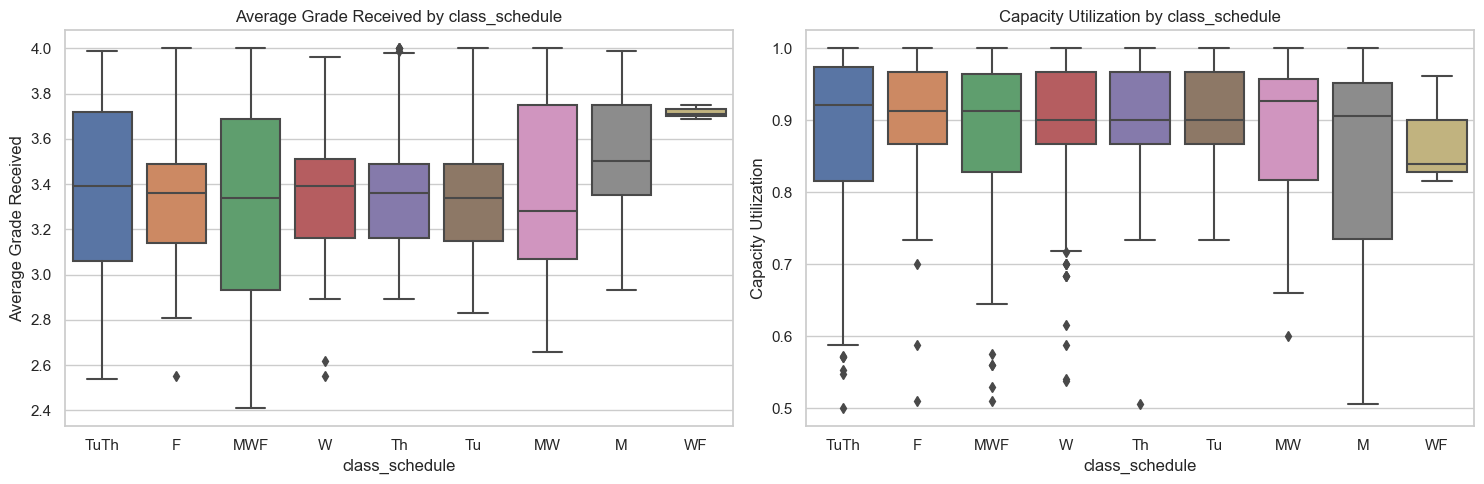

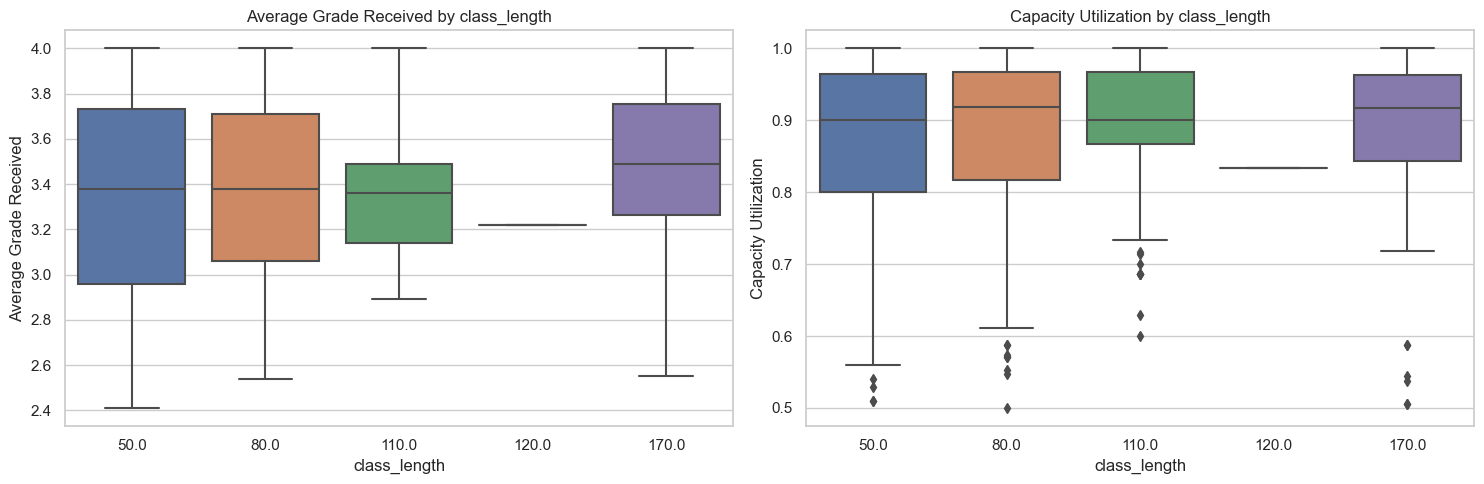

In [22]:
# Plot settings
sns.set(style="whitegrid")

# Define a function to create the boxplots
def plot_categorical_analysis(df, cat_var):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot avg_grade_rec distribution
    sns.boxplot(x=cat_var, y='avg_grade_rec', data=df, ax=axes[0])
    axes[0].set_title(f'Average Grade Received by {cat_var}')
    axes[0].set_xlabel(cat_var)
    axes[0].set_ylabel('Average Grade Received')

    # Plot capacity_utilization distribution
    sns.boxplot(x=cat_var, y='capacity_utilization', data=df, ax=axes[1])
    axes[1].set_title(f'Capacity Utilization by {cat_var}')
    axes[1].set_xlabel(cat_var)
    axes[1].set_ylabel('Capacity Utilization')

    plt.tight_layout()
    plt.show()

# Plot for department_name
plot_categorical_analysis(data, 'department_name')

# Plot for class_schedule
plot_categorical_analysis(data, 'class_schedule')

# Plot for class_length
plot_categorical_analysis(data, 'class_length')

> Pair Plot

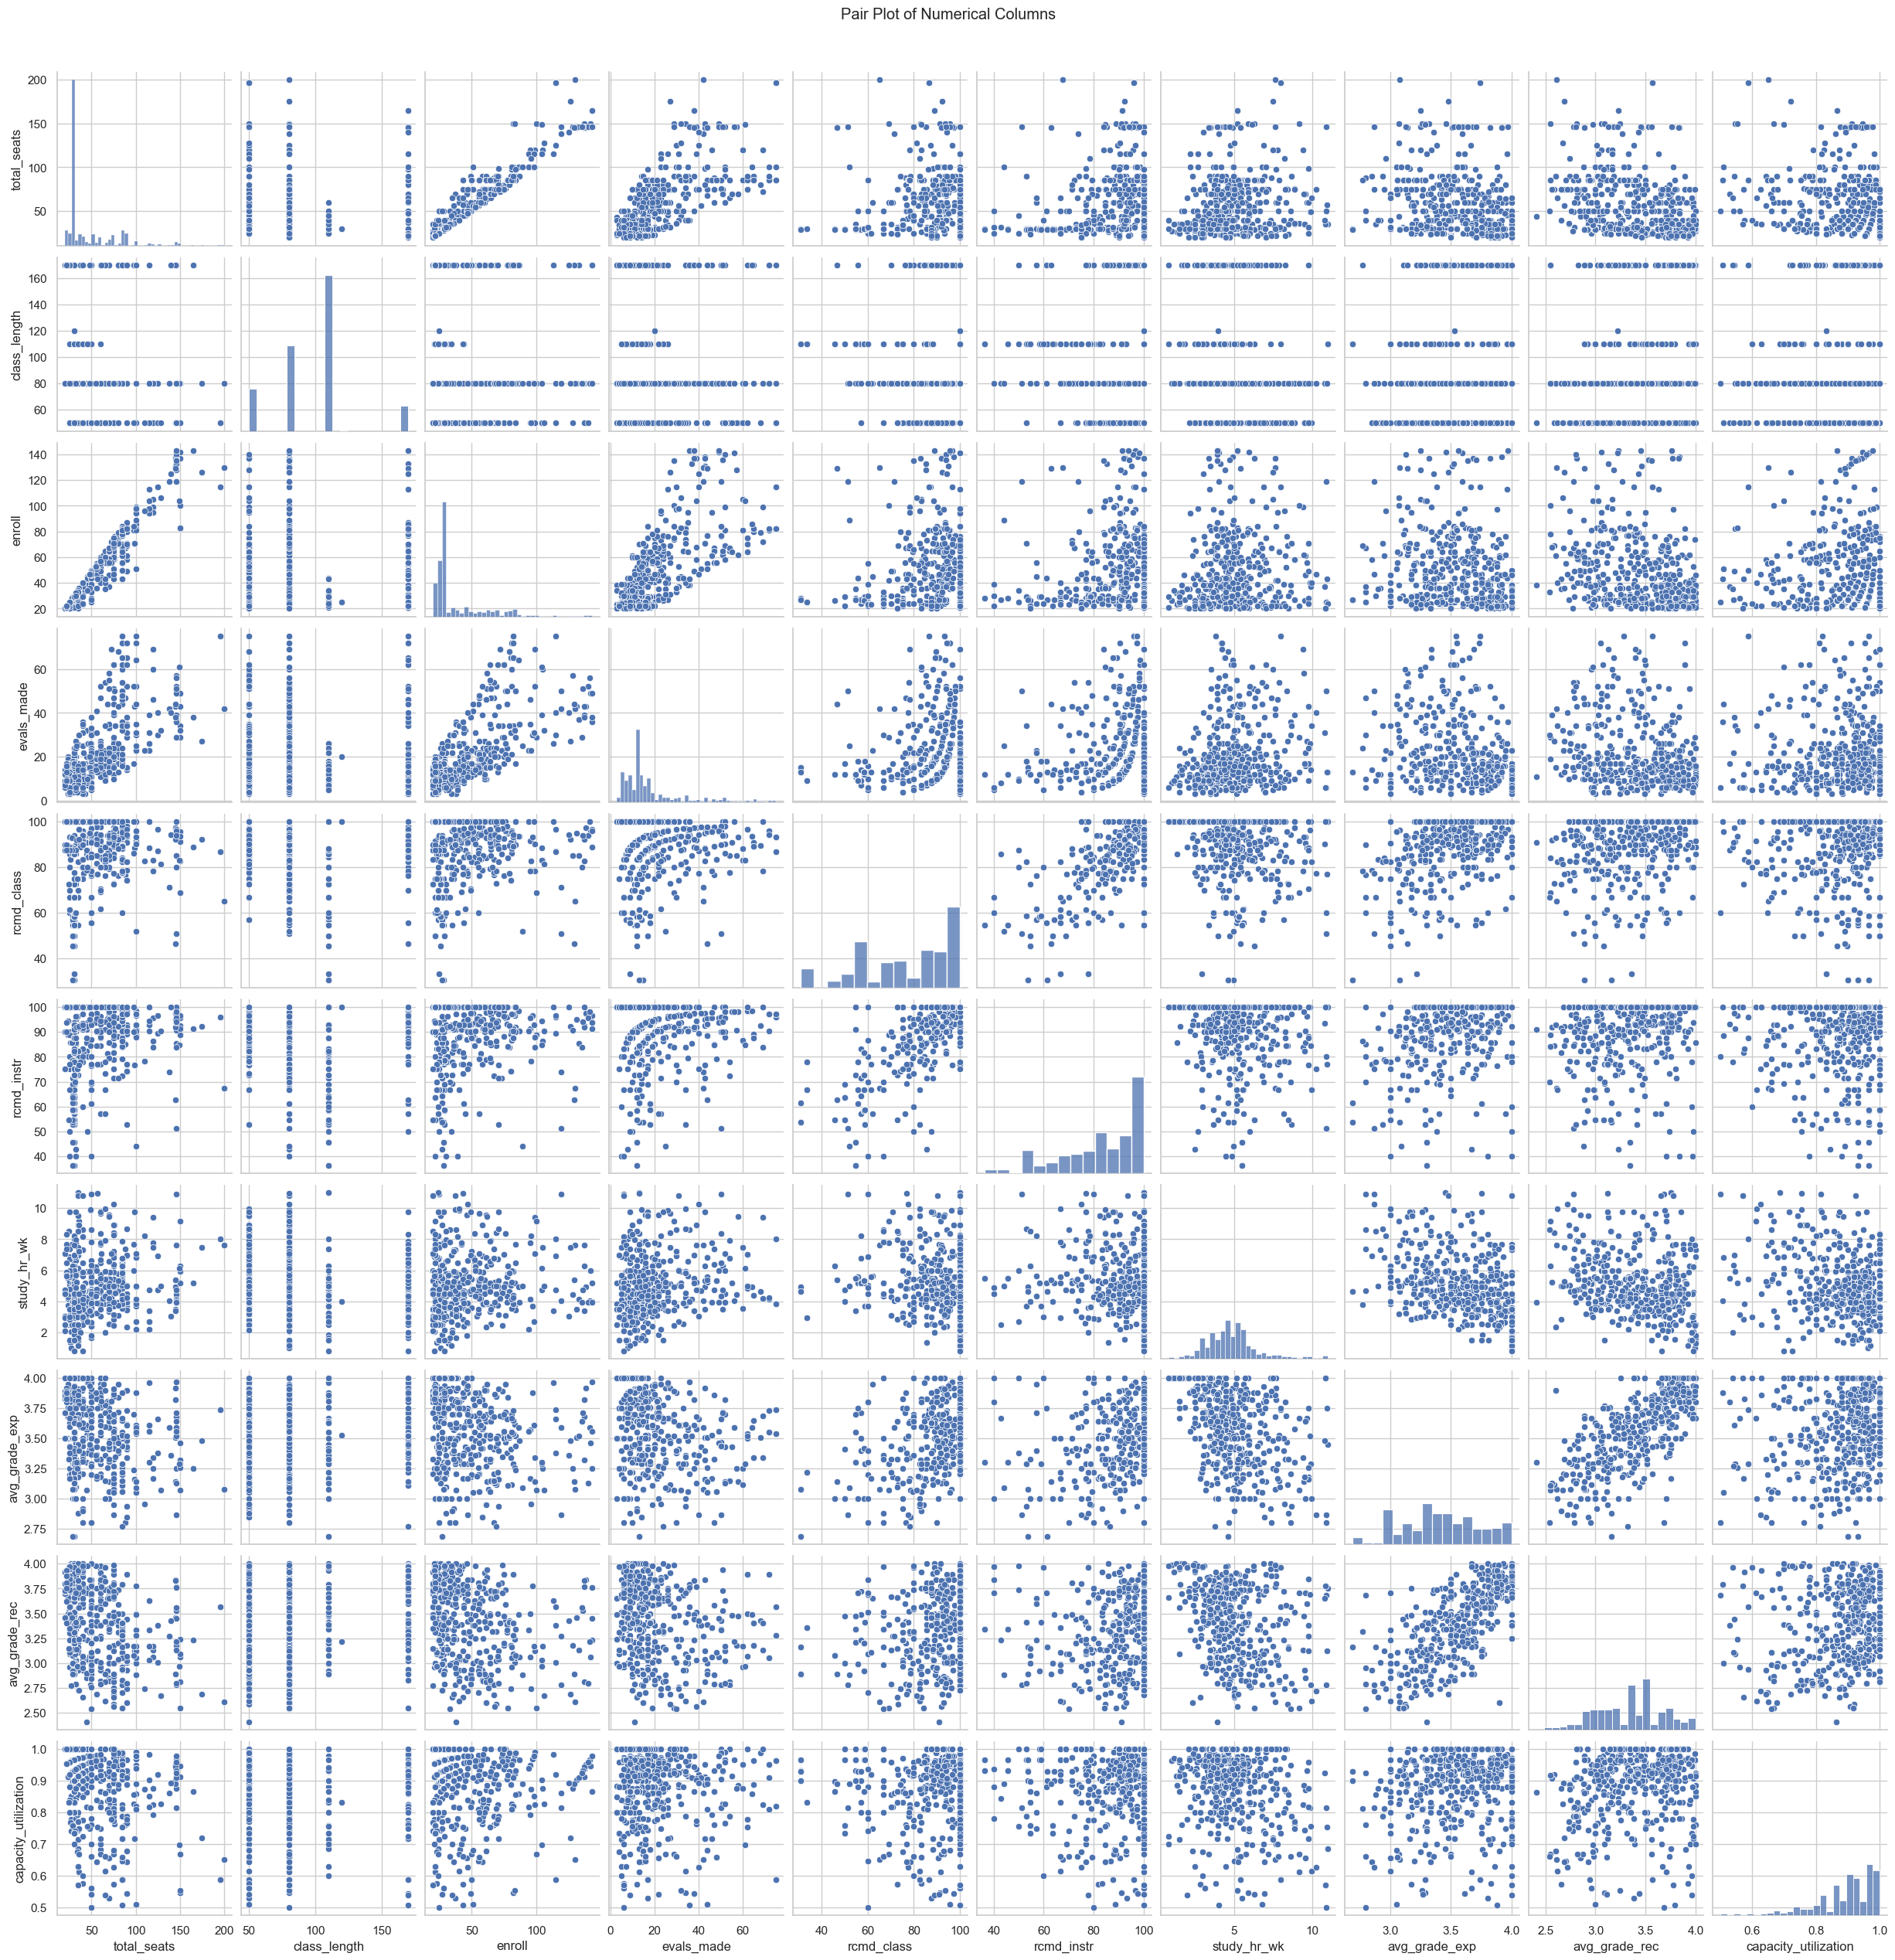

In [23]:
# Create pair plots for numerical columns
sns.pairplot(data[numerical_columns])
plt.suptitle('Pair Plot of Numerical Columns', y=1.02)
plt.show()

### Hypothesis Testing
#### ANOVA Test for Differences in Capacity Utilization Across Departments:
To assess whether there is a statistically significant variation in capacity utilization across different departments at UC San Diego, we employ ANOVA (Analysis of Variance):

- Null Hypothesis (H0): There is no significant difference in capacity utilization across departments.

- Alternative Hypothesis (Ha): There is a significant difference in capacity utilization across departments.

Test Statistics: We use the ANOVA F-statistic as our test statistic for this analysis. The ANOVA F-statistic is particularly suited for comparing the means of more than two groups simultaneously by analyzing the variance within each group compared to the variance between the groups.

Significance Level: We set a significance level at 5% for this test. If the p-value is less than 0.05, we reject the null hypothesis, indicating that at least one department has a significantly different capacity utilization rate compared to others.

ANOVA Test Execution:
We will compute the F-statistic and p-value using the 'capacity_utilization' across different 'department_name' groups in our data.


In [24]:
# ANOVA Test for Capacity Utilization Across Departments
# Extracting unique departments and their capacity utilization values
departments = data['department_name'].unique()
grouped_data = [data[data['department_name'] == dept]['capacity_utilization'] for dept in departments]

# Performing ANOVA
anova_results = stats.f_oneway(*grouped_data)
print(f"ANOVA results: F-statistic = {anova_results.statistic:.2f}, p-value = {anova_results.pvalue:.10f}")


ANOVA results: F-statistic = 4.65, p-value = 0.0000000000


> **Histograms** for numerical columns in subplots

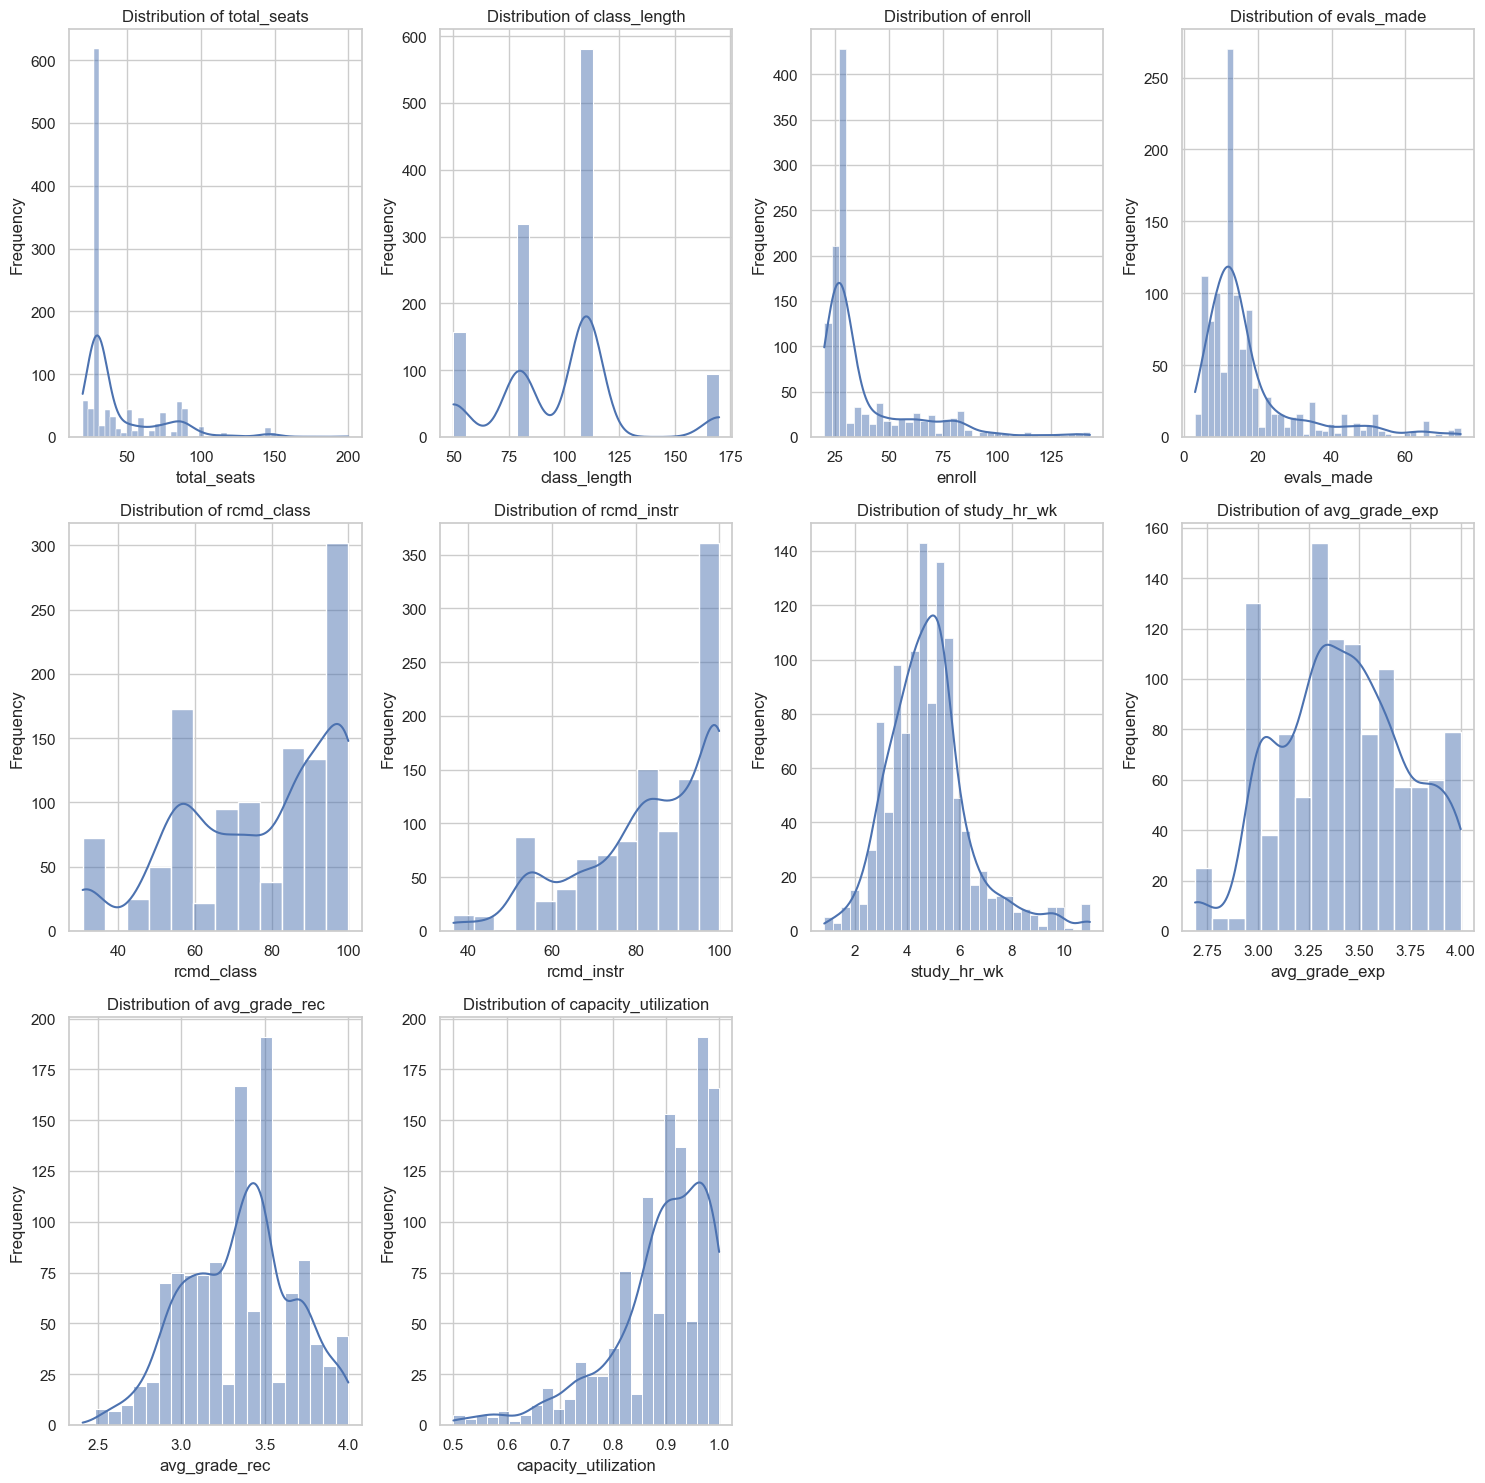

In [25]:
numerical_columns = data.select_dtypes(include=['float64']).columns

n_cols = 4
n_rows = int(np.ceil(len(numerical_columns) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

for i, col in enumerate(numerical_columns):
    row = i // n_cols
    col_pos = i % n_cols
    sns.histplot(data[col], kde=True, ax=axes[row, col_pos])
    axes[row, col_pos].set_title(f'Distribution of {col}')
    axes[row, col_pos].set_xlabel(col)
    axes[row, col_pos].set_ylabel('Frequency')

# Remove any empty subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

> Correlation matrix

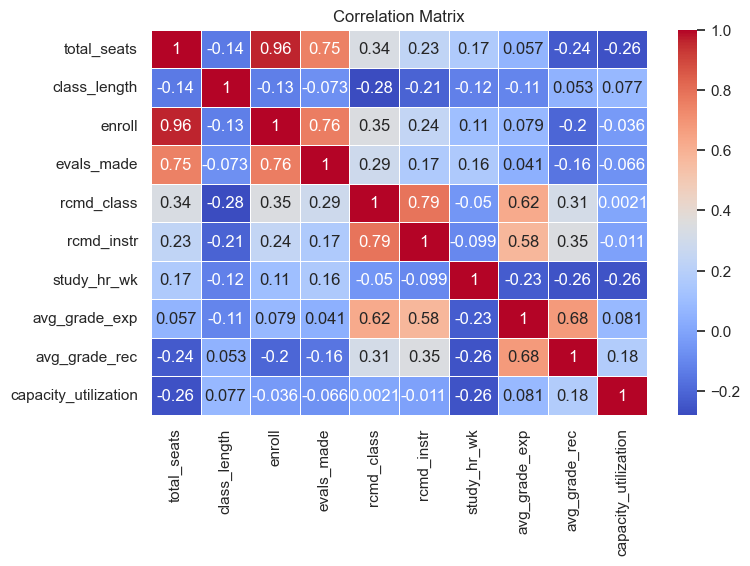

In [26]:
# Compute and visualize the correlation matrix
numerical_columns = data.select_dtypes(include=['float64']).columns
correlation_matrix = data[numerical_columns].corr()

plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

> Categorical Analysis

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1153 entries, 1 to 6851
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sub_course            1153 non-null   object 
 1   total_seats           1153 non-null   float64
 2   class_schedule        1153 non-null   object 
 3   class_length          1153 non-null   float64
 4   enroll                1153 non-null   float64
 5   evals_made            1153 non-null   float64
 6   rcmd_class            1153 non-null   float64
 7   rcmd_instr            1153 non-null   float64
 8   study_hr_wk           1153 non-null   float64
 9   avg_grade_exp         1153 non-null   float64
 10  avg_grade_rec         1153 non-null   float64
 11  department_name       1153 non-null   object 
 12  capacity_utilization  1153 non-null   float64
dtypes: float64(10), object(3)
memory usage: 126.1+ KB


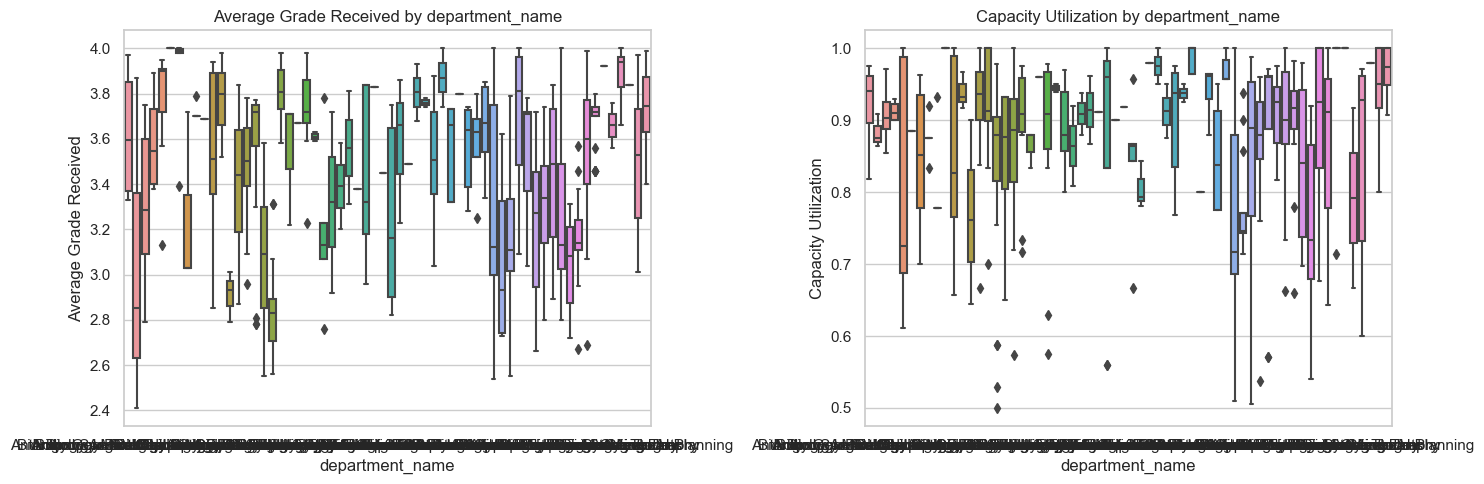

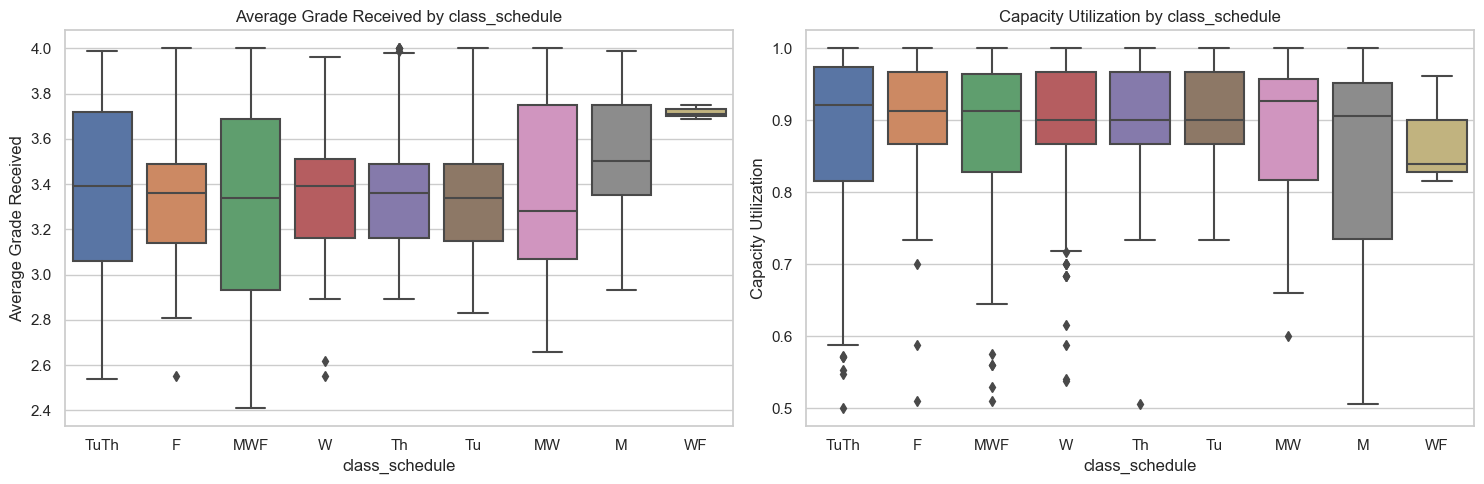

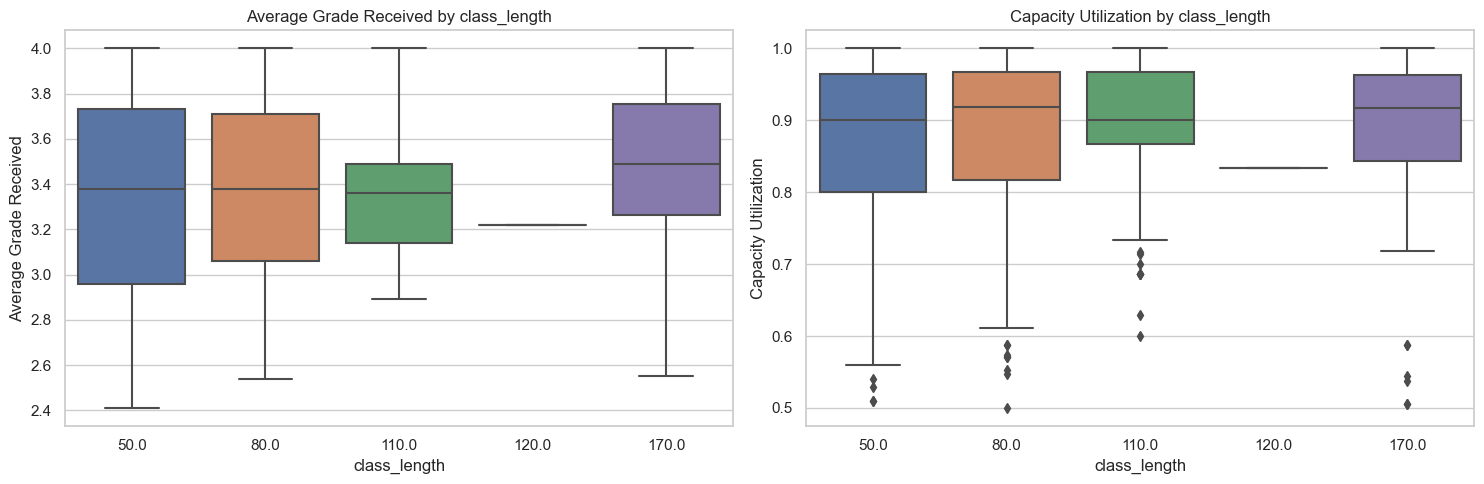

In [28]:
# Plot settings
sns.set(style="whitegrid")

# Define a function to create the boxplots
def plot_categorical_analysis(df, cat_var):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot avg_grade_rec distribution
    sns.boxplot(x=cat_var, y='avg_grade_rec', data=df, ax=axes[0])
    axes[0].set_title(f'Average Grade Received by {cat_var}')
    axes[0].set_xlabel(cat_var)
    axes[0].set_ylabel('Average Grade Received')

    # Plot capacity_utilization distribution
    sns.boxplot(x=cat_var, y='capacity_utilization', data=df, ax=axes[1])
    axes[1].set_title(f'Capacity Utilization by {cat_var}')
    axes[1].set_xlabel(cat_var)
    axes[1].set_ylabel('Capacity Utilization')

    plt.tight_layout()
    plt.show()

# Plot for department_name
plot_categorical_analysis(data, 'department_name')

# Plot for class_schedule
plot_categorical_analysis(data, 'class_schedule')

# Plot for class_length
plot_categorical_analysis(data, 'class_length')

> Pair Plot

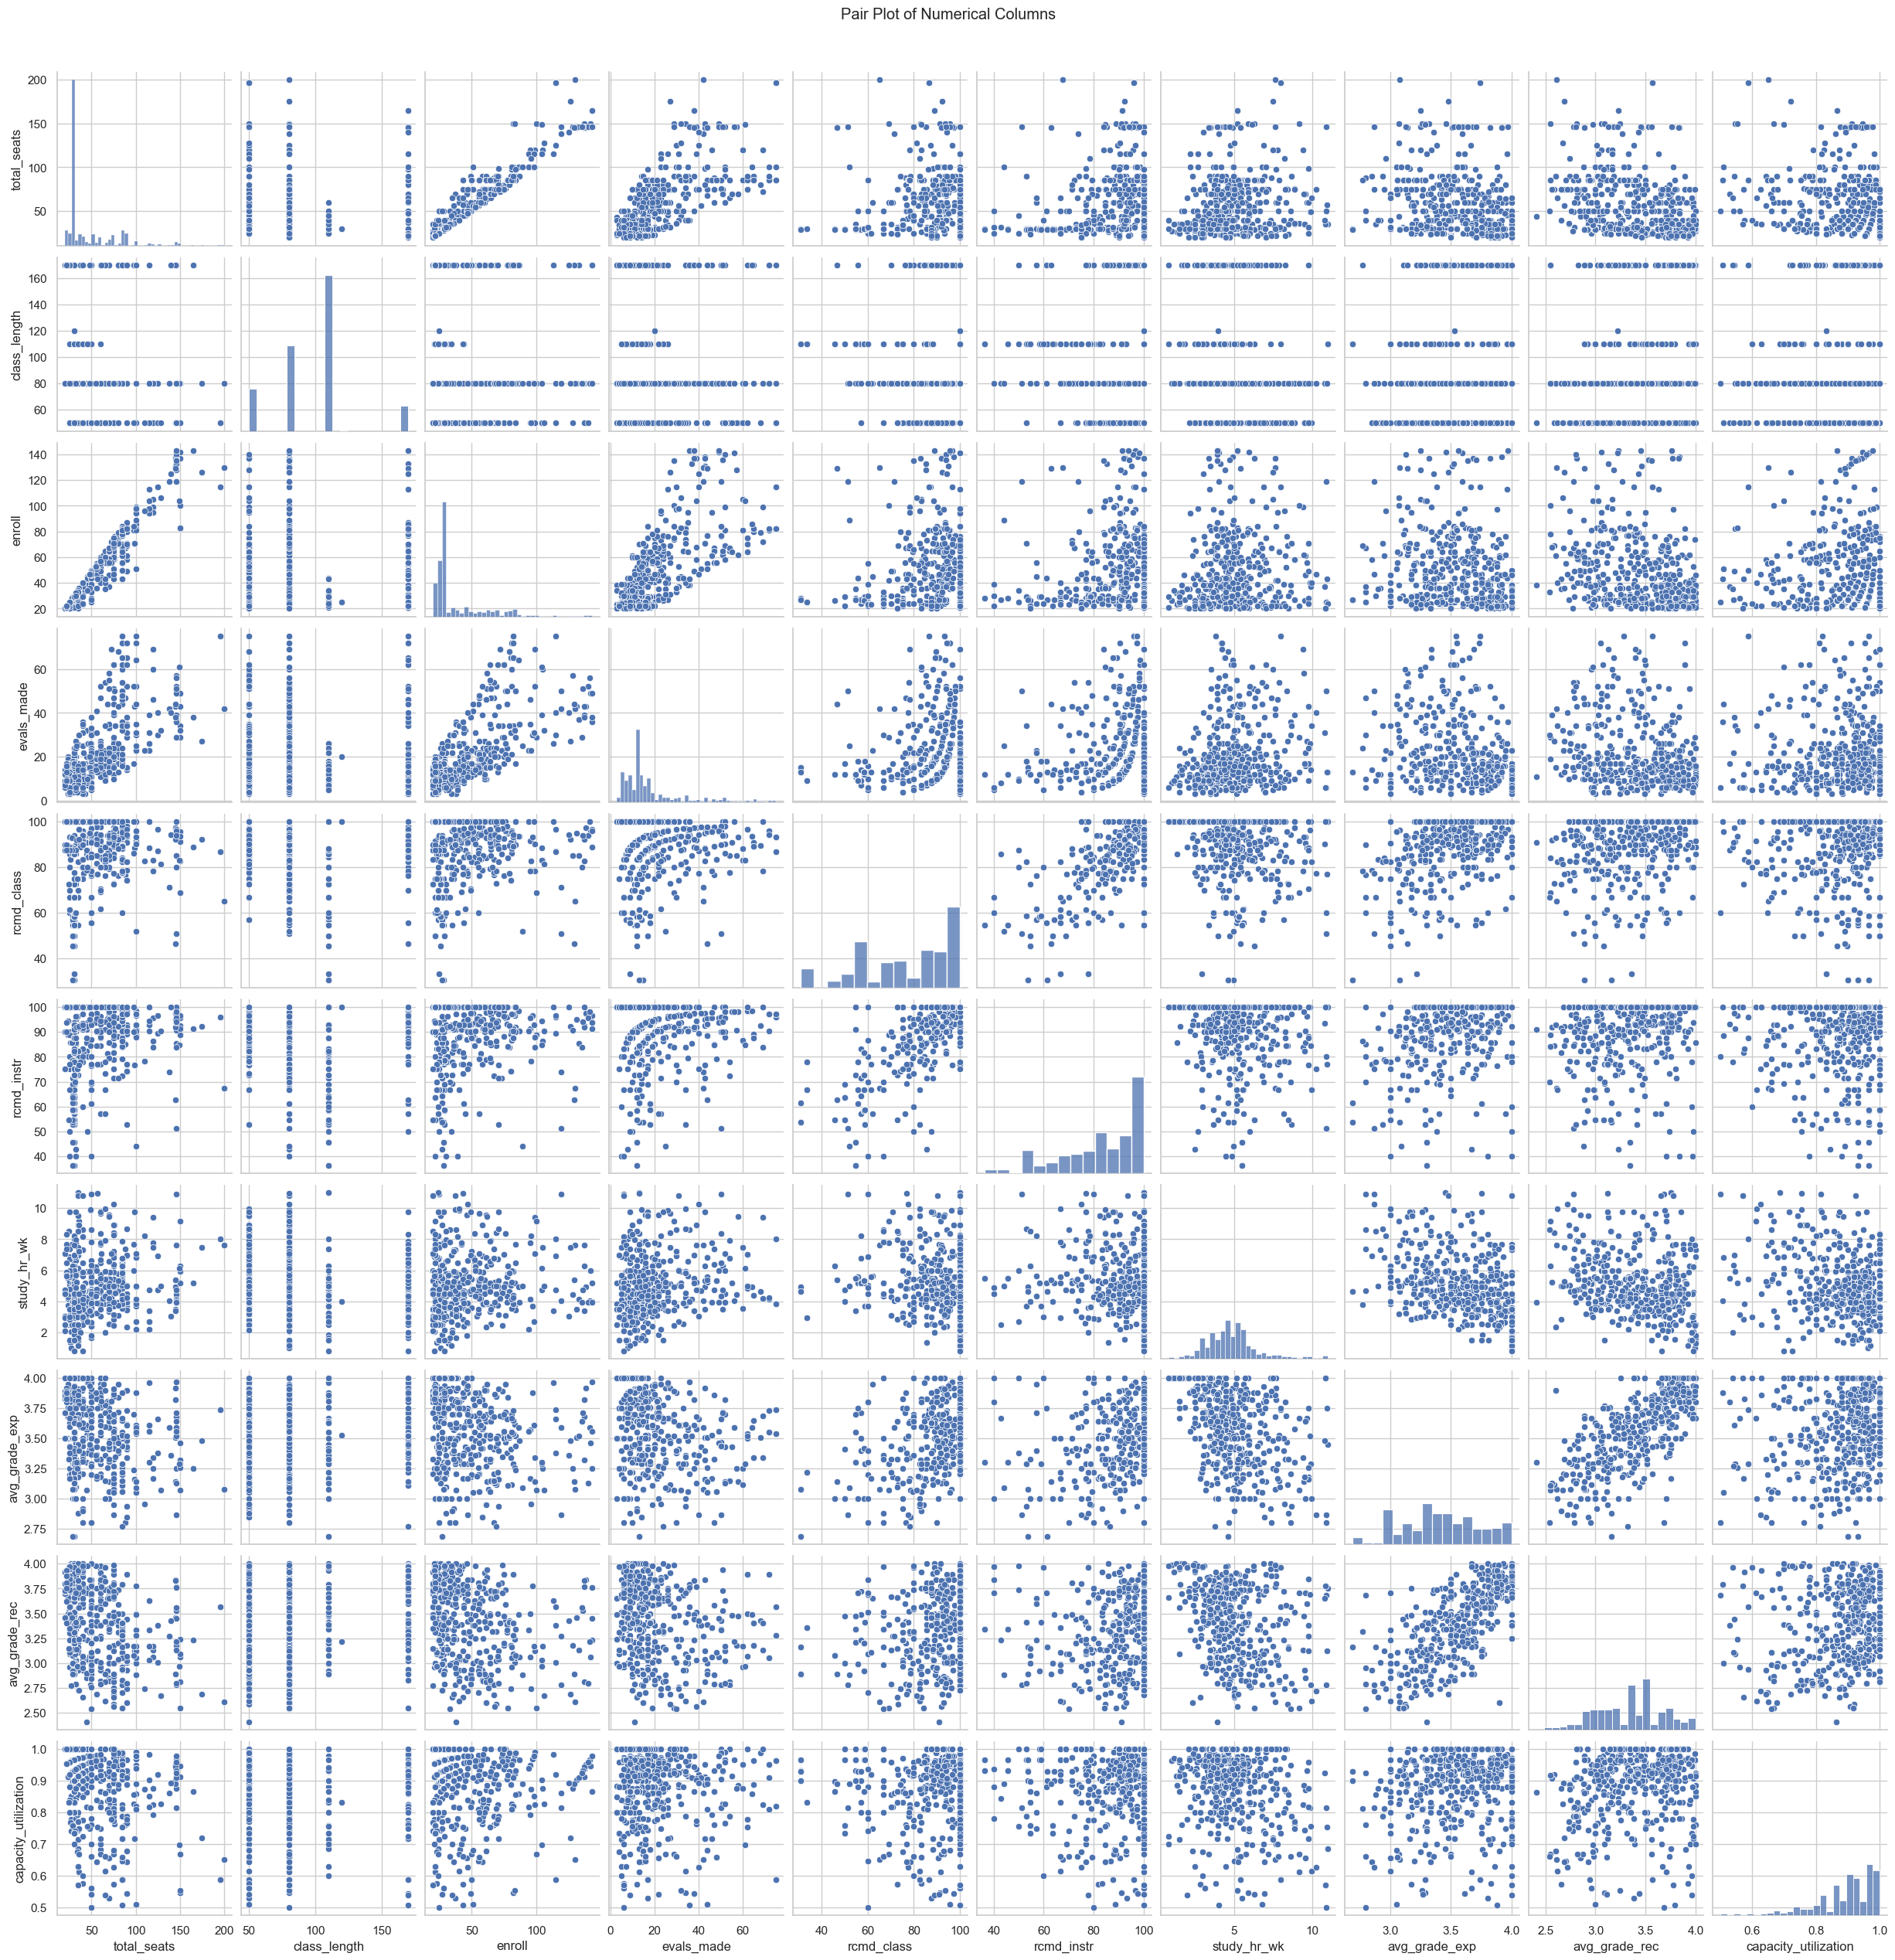

In [29]:
# Create pair plots for numerical columns
sns.pairplot(data[numerical_columns])
plt.suptitle('Pair Plot of Numerical Columns', y=1.02)
plt.show()

## Linear Regression

### Baseline Linear Full Regression model

In [30]:
# Define the formula including all relevant features
formula = 'avg_grade_rec ~ enroll + evals_made + rcmd_class + \
rcmd_instr + capacity_utilization + study_hr_wk + avg_grade_exp + C(department_name) + C(class_schedule) + C(class_length)'

# Fit the linear regression model using the formula
model = smf.ols(formula=formula, data=data).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          avg_grade_rec   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     31.60
Date:                Sun, 09 Jun 2024   Prob (F-statistic):          5.78e-228
Time:                        22:23:41   Log-Likelihood:                 370.79
No. Observations:                1153   AIC:                            -579.6
Df Residuals:                    1072   BIC:                            -170.5
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

> Model with statistically significant features (P-value < 0.05)

In [31]:
# Define the formula including all relevant features
formula_pvalue = 'avg_grade_rec ~ enroll + evals_made + \
rcmd_instr + capacity_utilization + study_hr_wk + avg_grade_exp + C(class_schedule) + C(department_name) + C(class_length)'

# Fit the linear regression model using the formula
model_p = smf.ols(formula=formula_pvalue, data=data).fit()

# Print the model summary
print(model_p.summary())

                            OLS Regression Results                            
Dep. Variable:          avg_grade_rec   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     32.00
Date:                Sun, 09 Jun 2024   Prob (F-statistic):          1.46e-228
Time:                        22:23:45   Log-Likelihood:                 370.39
No. Observations:                1153   AIC:                            -580.8
Df Residuals:                    1073   BIC:                            -176.8
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

### Assumption checking

> Check for Multicollinearity using VIF

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1153 entries, 1 to 6851
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sub_course            1153 non-null   object 
 1   total_seats           1153 non-null   float64
 2   class_schedule        1153 non-null   object 
 3   class_length          1153 non-null   float64
 4   enroll                1153 non-null   float64
 5   evals_made            1153 non-null   float64
 6   rcmd_class            1153 non-null   float64
 7   rcmd_instr            1153 non-null   float64
 8   study_hr_wk           1153 non-null   float64
 9   avg_grade_exp         1153 non-null   float64
 10  avg_grade_rec         1153 non-null   float64
 11  department_name       1153 non-null   object 
 12  capacity_utilization  1153 non-null   float64
dtypes: float64(10), object(3)
memory usage: 126.1+ KB


In [33]:
# Create a copy of the data to keep the original data unchanged
df = data.copy()

# Drop 'sub_course' column from the copy
df = df.drop(columns=['sub_course'])

# Create dummy variables for categorical features in the copy
df = pd.get_dummies(df, drop_first=True, dtype = 'int')

# Define the features matrix X and the target vector y from the copy
X = df.drop(columns=['avg_grade_rec'])
y = df['avg_grade_rec']

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                                       feature         VIF
0                                  total_seats  151.410281
1                                 class_length   53.911198
2                                       enroll  161.099779
3                                   evals_made    8.943361
4                                   rcmd_class   74.463332
..                                         ...         ...
73              department_name_Theatre Acting    5.790837
74             department_name_Theatre General    1.640279
75    department_name_Theatre History & Theory    1.267985
76  department_name_Urban Studies and Planning    2.324842
77                 department_name_Visual Arts    4.276285

[78 rows x 2 columns]


In [34]:
vif_data[10:30]

feature        VIF
10                                  class_schedule_MW   3.446003
11                                 class_schedule_MWF   8.614318
12                                  class_schedule_Th   2.867328
13                                  class_schedule_Tu   2.915862
14                                class_schedule_TuTh  10.941019
15                                   class_schedule_W   2.480550
16                                  class_schedule_WF   1.144065
17        department_name_Anthropological Archaeology   1.581296
18                       department_name_Anthropology   1.575492
19  department_name_Anthropology Biological Anthro...   1.399306
20                     department_name_Bioengineering   3.161002
21  department_name_Biology Animal Physiology and ...   1.857517
22  department_name_Biology Genetics Cellular and ...   1.158764
23  department_name_Biology Molecular Biology Micr...   2.409248
24            department_name_Biology Special Studies   1.716011
25               department_name_Chemical Engineering   2.514765
26         department_name_Chemistry and Biochemistry   1.414884
27                  department_name_Cognitive Science   2.453897
28                      department_name_Communication   3.139625
29   department_name_Computer Science and Engineering   4.435040

> Re-test model after using VIF to filter **multicolinearity** (threshold < 20)

In [35]:
# Define the formula
formula2 = 'avg_grade_rec ~ evals_made + study_hr_wk + C(department_name) + C(class_schedule) + C(class_length)'

# Fit the linear regression model using the formula
model2 = smf.ols(formula=formula2, data=data).fit()

# Print the model summary
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:          avg_grade_rec   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     14.70
Date:                Sun, 09 Jun 2024   Prob (F-statistic):          1.69e-118
Time:                        22:23:54   Log-Likelihood:                 78.804
No. Observations:                1153   AIC:                            -5.608
Df Residuals:                    1077   BIC:                             378.2
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

### Other model assumption checks

> Check **Linearity/homoscedasticity** with residual plot

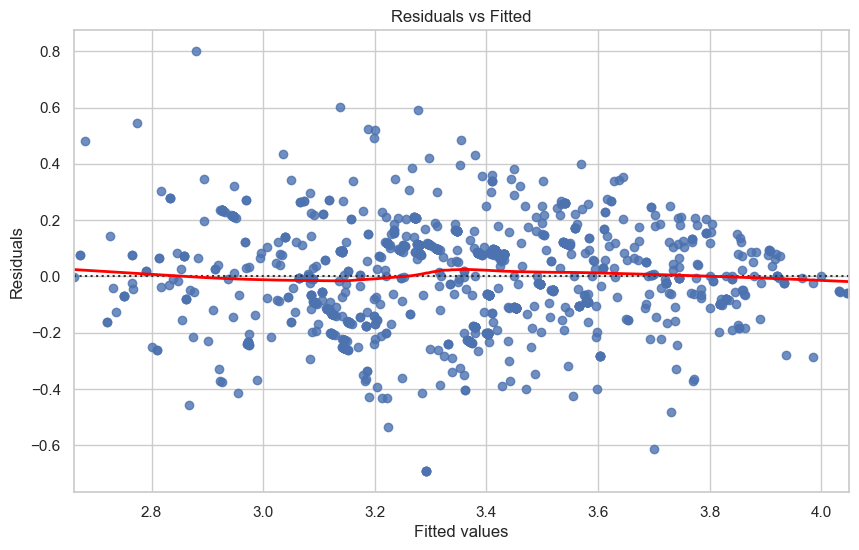

In [36]:
# Plot residuals
residuals = model.resid

# 1. Residual Plot
plt.figure(figsize=(10, 6))
sns.residplot(x=model.fittedvalues, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2})
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

> Check the **normality** of residuals with QQ plot

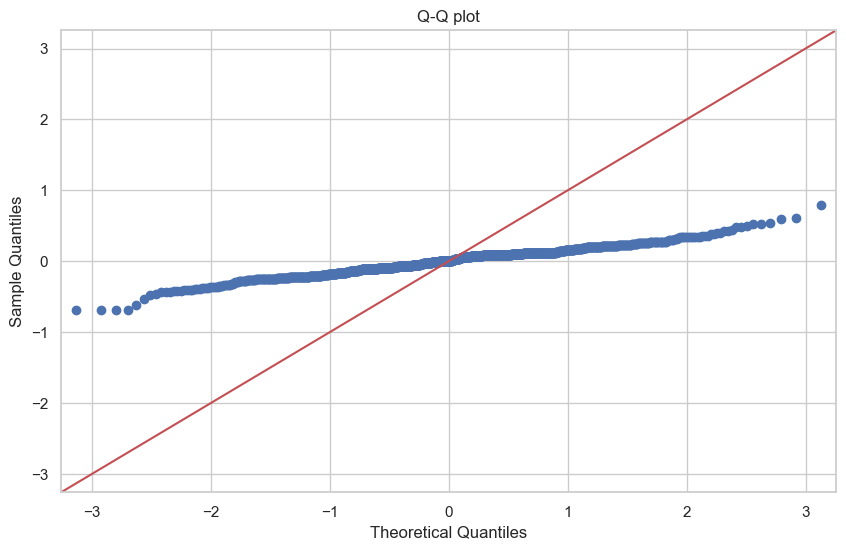

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))
sm.qqplot(residuals, line='45', ax=ax)
plt.title('Q-Q plot')
plt.show()

> Check the **normality** of residuals with shapiro-wilk test

In [38]:
# 3. Shapiro-Wilk Test
shapiro_test = shapiro(residuals)
print(f'Shapiro-Wilk test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}')

Shapiro-Wilk test: Statistic=0.9841938018798828, p-value=7.22658710650137e-10


Despite the test statistic being close to 1, the extremely small p-value indicates that the residuals are not normally distributed according to the Shapiro-Wilk test, which align with the QQ plot we get above.

> Backward feature selection based on BIC criterion

In [39]:
# Define the criterion for BIC
criterion = lambda formula, df: smf.ols(formula, data=df).fit().bic

# Define the remove function
def remove(df, selected_columns, criterion, response='y'):
    worst_criterion = np.inf
    worst_column = None
    for column in selected_columns:
        new_columns = selected_columns - {column}
        formula = f'{response} ~ {" + ".join(new_columns)}'
        current_criterion = criterion(formula, df)
        if current_criterion < worst_criterion:
            worst_criterion = current_criterion
            worst_column = column
    return worst_column, worst_criterion

# Define the backward function
def backward(df, criterion, response='y'):
    selected_columns = set(df.columns.drop(response))
    best_criterion = np.inf
    while len(selected_columns) > 0:
        potential_column, current_criterion = remove(df, selected_columns, criterion, response)
        if current_criterion > best_criterion:
            break
        else:
            selected_columns = selected_columns - {potential_column}
            best_criterion = current_criterion
            print(f'Criterion: {best_criterion}')
    return selected_columns

In [40]:
# Add the response variable to the DataFrame for backward selection
data_for_backward = data[[
    'avg_grade_rec',
    'enroll',
    'evals_made',
    'rcmd_class',
    'rcmd_instr',
    'capacity_utilization',
    'study_hr_wk',
    'avg_grade_exp',
    'department_name',
    'class_schedule',
    'class_length'
]]

# Perform backward selection based on BIC
selected_columns = backward(data_for_backward, criterion, response='avg_grade_rec')
print(f'Selected features: {selected_columns}')

Criterion: -211.99823108687195
Criterion: -218.59628379790274
Selected features: {'enroll', 'study_hr_wk', 'evals_made', 'department_name', 'capacity_utilization', 'avg_grade_exp', 'rcmd_instr', 'class_length'}


In [41]:
# Response variable
response = 'avg_grade_rec'

# Create the formula
formula3 = 'avg_grade_rec ~ evals_made + C(department_name) + C(class_length) + enroll + capacity_utilization + rcmd_instr + avg_grade_exp + study_hr_wk'

# Fit the model using the formula
model3 = smf.ols(formula3, data=data).fit()

# Print the model summary
print(model3.summary())

# Predict values using the model
df['predicted_avg_grade_rec'] = model3.predict(data)

                            OLS Regression Results                            
Dep. Variable:          avg_grade_rec   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     34.69
Date:                Sun, 09 Jun 2024   Prob (F-statistic):          2.24e-229
Time:                        22:24:01   Log-Likelihood:                 356.93
No. Observations:                1153   AIC:                            -569.9
Df Residuals:                    1081   BIC:                            -206.3
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

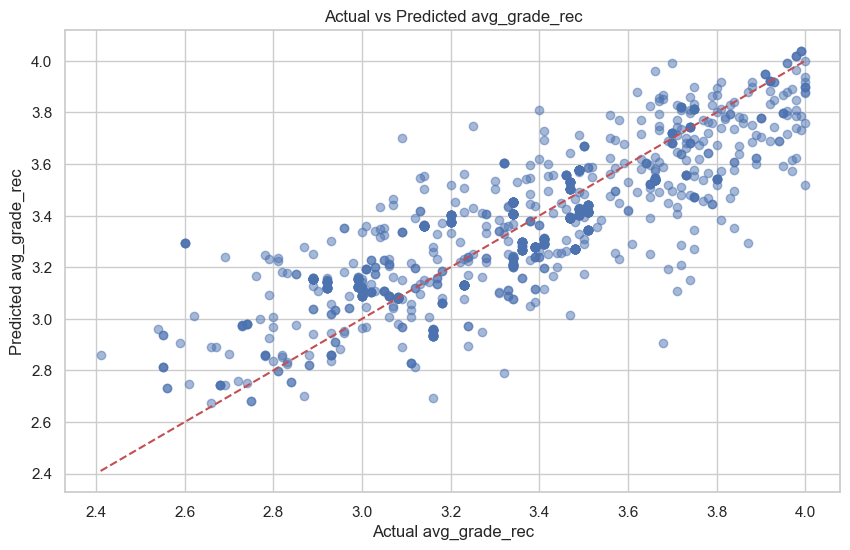

In [42]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(data['avg_grade_rec'], df['predicted_avg_grade_rec'], alpha=0.5)
plt.plot([data['avg_grade_rec'].min(), data['avg_grade_rec'].max()], [data['avg_grade_rec'].min(), data['avg_grade_rec'].max()], 'r--')
plt.xlabel('Actual avg_grade_rec')
plt.ylabel('Predicted avg_grade_rec')
plt.title('Actual vs Predicted avg_grade_rec')
plt.show()

### Proceed with heavier punishment on complexity with regularization

> Perform Ridge/Lasso regression on our model

#### Ridge regression

In [43]:
data.head()

sub_course  total_seats class_schedule  class_length  enroll  evals_made  \
1   ANAR 143         44.0           TuTh          80.0    36.0         7.0   
2   ANAR 146         80.0           TuTh          80.0    78.0        20.0   
3   ANAR 155         24.0              F         170.0    23.0        16.0   
4   ANAR 156         39.0           TuTh          80.0    36.0        10.0   
6   ANBI 121         40.0           TuTh          80.0    35.0        25.0   

   rcmd_class  rcmd_instr  study_hr_wk  avg_grade_exp  avg_grade_rec  \
1        85.7        85.7         4.50           3.57           3.33   
2        95.0       100.0         5.80           3.84           3.38   
3       100.0       100.0         2.63           3.94           3.97   
4        80.0       100.0         4.30           3.70           3.81   
6        95.8       100.0         3.46           3.92           3.87   

                        department_name  capacity_utilization  
1           Anthropological Archaeology                 0.818  
2           Anthropological Archaeology                 0.975  
3           Anthropological Archaeology                 0.958  
4           Anthropological Archaeology                 0.923  
6  Anthropology Biological Anthropology                 0.875

In [44]:
# Prepare the feature matrix and target variable
df = data.copy()
# Drop 'sub_course' column from the copy
df = df.drop(columns=['sub_course'])

X = df.drop(columns=['avg_grade_rec'])
y = data['avg_grade_rec']

# Encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)


# Apply Ridge regression
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_train, y_train)
ridge_predictions = ridge_model.predict(X_test)

# Evaluate Ridge model
ridge_mae = mean_absolute_error(y_test, ridge_predictions)
ridge_mse = mean_squared_error(y_test, ridge_predictions)
ridge_r2 = r2_score(y_test, ridge_predictions)

print(f'Ridge Regression - MAE: {ridge_mae}, MSE: {ridge_mse}, R2: {ridge_r2}')

Ridge Regression - MAE: 0.16038791072857533, MSE: 0.04003544612209504, R2: 0.4951569457507967


#### Lasso regression

In [45]:
# Apply Lasso regression
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X_train, y_train)
lasso_predictions = lasso_model.predict(X_test)

# Evaluate Lasso model
lasso_mae = mean_absolute_error(y_test, lasso_predictions)
lasso_mse = mean_squared_error(y_test, lasso_predictions)
lasso_r2 = r2_score(y_test, lasso_predictions)

print(f'Lasso Regression - MAE: {lasso_mae}, MSE: {lasso_mse}, R2: {lasso_r2}')

Lasso Regression - MAE: 0.15603555151870704, MSE: 0.03687471310334451, R2: 0.5350134795330366


> Principal Component Analysis

In [46]:
# Prepare the feature matrix and target variable with all features
y = data['avg_grade_rec']

# Encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.9)  # Retain 95% of the variance
X_pca = pca.fit_transform(X_scaled)

# Check the explained variance ratio
print(f'Explained variance ratio: {pca.explained_variance_ratio_}')
print(f'Number of components: {pca.n_components_}')

Explained variance ratio: [0.06515422 0.03633703 0.02890387 0.02073052 0.01924542 0.01887905
 0.0171366  0.01648428 0.01606795 0.01572095 0.01424955 0.01389625
 0.01383074 0.0134091  0.01313547 0.01308417 0.01307588 0.01302506
 0.01300441 0.0129931  0.01298298 0.01297792 0.01297358 0.01296316
 0.01295649 0.01294736 0.01294435 0.01294345 0.01293485 0.01292437
 0.0129126  0.01290619 0.01290292 0.01289764 0.01289335 0.01288228
 0.01288188 0.01288018 0.01287297 0.0128725  0.0128697  0.01286817
 0.0128609  0.01285852 0.01285595 0.01285482 0.01285236 0.01284893
 0.01284764 0.01284609 0.01284463 0.01284335 0.01284299 0.01284077
 0.01283737 0.01283427 0.01283307 0.01283242 0.01283201 0.01283171]
Number of components: 60


Ridge Regression with PCA - MAE: 0.7203320797621094, MSE: 20.406850292719295, R2: -214.58710272794315


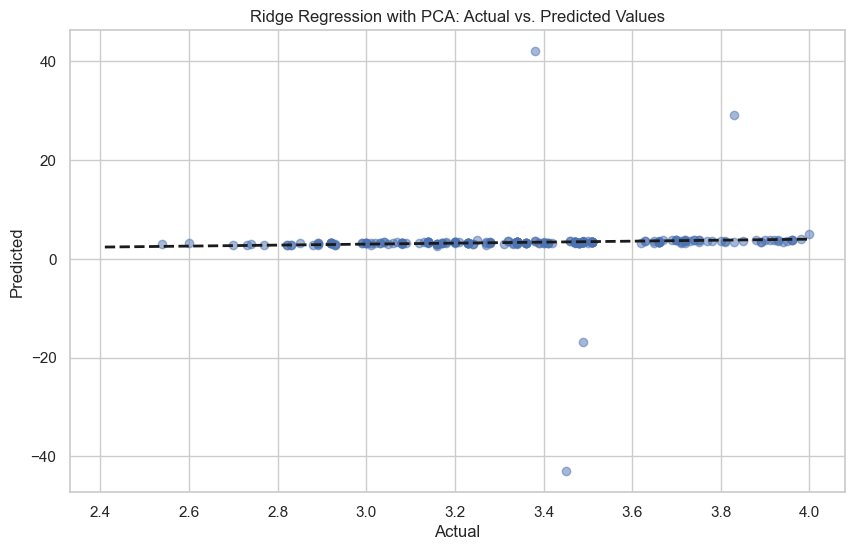

In [47]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Apply Ridge regression
ridge_model = Ridge(alpha=0.01)
ridge_model.fit(X_train, y_train)
ridge_predictions = ridge_model.predict(X_test)

# Evaluate Ridge model
ridge_mae = mean_absolute_error(y_test, ridge_predictions)
ridge_mse = mean_squared_error(y_test, ridge_predictions)
ridge_r2 = r2_score(y_test, ridge_predictions)

print(f'Ridge Regression with PCA - MAE: {ridge_mae}, MSE: {ridge_mse}, R2: {ridge_r2}')

# Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, ridge_predictions, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Ridge Regression with PCA: Actual vs. Predicted Values')
plt.show()